# Bottled Gazpacho Market Research 5 (0 - 4 scale)

I don't know about you, but I love Gazpacho. In Spain they sell those delicacies bottled in supermarkets. But what about the rest of the world? How sad I am eveytime I go to the supermarket and none of that elixir is available. Here's the wonderful sight that Spaniards take for granted, while everyone else can only dream of:

![gazpacho](./images/spanish_bottled_gazpacho.jpg)

No more! This stops here! Or so I hope. Let's perform some **simulated market research** to find out if there is a market for Gazpacho in the rest of the world.

In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe import config_manager
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler

from tinytroupe.validation import SimulationExperimentEmpiricalValidator, SimulationExperimentDataset, validate_simulation_experiment_empirically


!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: c:\Users\pdasilva\repos\TinyTroupe\examples\config.ini
TinyTroupe version: 0.6.0
Current date and time (local): 2025-10-02 11:16:41
Current date and time (UTC):   2025-10-02 14:16:41

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-5-mini
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
max_completion_tokens = 32000
timeout = 480
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
reasoning_effort = high
cache_api_calls = False
cache_file_name = openai_api_cache.pickle
max_content_display_l

In [2]:
#config_manager.update("action_generator_enable_quality_checks", True)
#config_manager.update("action_generator_quality_threshold", 6)

First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [3]:
#control.begin("bottled_gazpacho_market_research_5.cache.json")

## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [4]:
target_nationality = "American"
population_size = 50

additional_demographic_specification = f"""
BESIDES other dimensions infered from the population demographic data (i.e., make sure those are still present), 
ensure these ADDITIONAL sampling dimensions are present, which must be as realistic as possible:
  - general attitude: from positive to negative, from optimistic to pessimistic, from open-minded to closed-minded
  - education: from the completely illiterate (can't even talk properly) to the highest scientist
  - culinary tastes: from traditional to modern, from spicy to mild, from vegetarian to meat-based
  - shopping habits: from frequent to occasional, from online to in-store, from frugal to extravagant
  - health consciousness: from health-focused to indulgent, from organic to conventional
  - attitude towards new products: from open-minded to skeptical, from adventurous to conservative
  - cultural influences: from local to global, from traditional to contemporary, from diverse to homogeneous
  - travel habits: from frequent travelers to homebodies, from local to international, from adventurous to cautious
  - cultural background: from diverse to homogeneous, from traditional to modern, from local to global
  - lifestyle: from active to sedentary, from urban to rural, from minimalist to extravagant

Each of these additional dimensions MUST have AT LEAST 10 values. 
For all of these, YOU MUST provide long, detailed sentences that describe the values in each dimension. NOT short
words. We need EACH value to be VERY detailed.

Make sure you also include EXTREME values so that we can properly capture even edge cases. We want a WIDE
range of different people and tastes!
"""
  

Descriptions and standard questions for the survey.

In [5]:
interviewer_introduction =\
    """
    We are performing some market research and need to know you more. 
    Can you please present yourself and also list your top-10 interests?
    """

interviewer_main_question =\
    """ 
    Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with tomatoes, cucumbers, peppers, and olive oil. 
    We are considering offering it in supermarkets near you.

    Would you consider purchasing ready-to-drink bottled gazpacho if it was available at your local supermarket? How much do you like this idea? 

    Please rate your propensity of purchasing it (from 1 to 5), where:
       - 1: would NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
       - 2: very unlikely, but not impossible.
       - 3: maybe I would buy it, not sure.
       - 4: it is very likely.
       - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
    
    Please just give your number and justification, and then you are done. Giving a number helps us compile the data, so use it please.
    """

inner_monologue =\
    """
    I will be honest as I understand they are not here to judge me, but just to learn from me. 
    Such choices depend on many factors, but I will make my best guess, considering my current 
    situation in life, location, job and interests. I will not refrain from giving extreme answers, 
    such as 1 or 5, if that's how I really feel, as this exercise requires me to be honest, human and realistic.

    Now I **must** first THINK deeply about the question, consider all the factors that might influence my decision,
    and only then I will TALK with my response to the question as best, as detailed and as honestly as I can.

    My answer will be something like "My propensity is X, because ...", always stating the propensity score and justifying it later.
    """

Common mechaniss.

In [6]:
results_extractor = ResultsExtractor(extraction_objective="Find whether the person would buy the product. A person rate his/her propensity from 1 (would NEVER buy) to 5 (would CERTAINLY buy it)." ,
                                     situation="Agent was asked to rate their interest in a bottled Gazpacho. They can respond with a propensity score from 1 (would NEVER buy) to 5 (would CERTAINLY buy it).", 
                                     fields=["name", "response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as '1', '2', '3', '4', '5' or 'N/A'(if there is no response or you cannot determine the precise response)."},
                                     verbose=True)

A function that will give us the statistics and then recommend us if we should go ahead and start a Gazpacho business.

In [7]:
def is_there_a_good_market(df, positive_threshold=0.1, negative_threshold=0.5):
    # Convert responses to strings for consistent handling
    df_copy = df.copy()
    df_copy["response"] = df_copy["response"].astype(str)
    
    # Get counts and calculate percentages
    counts = df_copy["response"].value_counts()
    total = counts.sum()
    percentage = counts / total
    
    # Calculate percentages by rating category (using 1-5 scale)
    percentage_positive = percentage.get("4", 0) + percentage.get("5", 0)
    percentage_neutral = percentage.get("3", 0)
    percentage_negative = percentage.get("1", 0) + percentage.get("2", 0)
    percentage_na = percentage.get("N/A", 0)
    
    # Print the analysis
    print(f"Percentage of positive responses (4-5): {percentage_positive:.2%}")
    print(f"Percentage of neutral responses (3): {percentage_neutral:.2%}")
    print(f"Percentage of negative responses (1-2): {percentage_negative:.2%}")
    print(f"Percentage of 'N/A' responses: {percentage_na:.2%}")

    # also compute the mean and standard deviation of the responses
    df_copy["response"] = pd.to_numeric(df_copy["response"], errors='coerce')
    mean_response = df_copy["response"].mean()
    std_response = df_copy["response"].std()

    print(f"Mean response: {mean_response:.2f}")
    print(f"Standard deviation of responses: {std_response:.2f}")

    # Decision based on thresholds
    if percentage_positive > positive_threshold and percentage_negative < negative_threshold:
        print("VERDICT: There is a good market for bottled gazpacho.")
        return True
    else:
        print("VERDICT: There is not a good market for bottled gazpacho.")
        return False



## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [8]:
factory = TinyPersonFactory.create_factory_from_demography("./information/populations/usa.json", 
                                                           population_size=population_size, 
                                                           additional_demographic_specification=additional_demographic_specification)

In [9]:
people = factory.generate_people(population_size, verbose=True)

2025-10-02 11:19:17,341 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 11:19:17,503 - tinytroupe - INFO - Sampling dimensions computed successfully.
2025-10-02 11:20:41,761 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 11:20:41,774 - tinytroupe - INFO - Sampling plan computed successfully.
2025-10-02 11:20:41,784 - tinytroupe - INFO - Sample plan has been flattened, contains 50 total samples.
2025-10-02 11:20:53,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 11:21:10,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 11:21:22,925 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 11:21:44,294 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 O

In [10]:
factory.sampling_dimensions

{'sampling_space_description': 'Comprehensive sampling space for the United States population as specified in the input data and directives: includes demographic proportions (age, sex, race/ethnicity, region, income, education), personality/political/economic beliefs, financial situation, preferences and tastes, cultural background, and many additional richly described lifestyle and attitudinal dimensions required by the brief.',
 'dimensions': [{'name': 'age', 'range': [0, 100]},
  {'name': 'age_group',
   'values': {'0-14: young children and early adolescents, typically living with parents or guardians and shaped by family routines, early schooling, and dependent consumption patterns': 0.186,
    '15-24: older adolescents and young adults navigating secondary school, higher education or early careers, with high digital engagement and evolving independence': 0.131,
    '25-54: core working-age adults balancing career building, family formation, and housing and consumer decisions': 0.3

In [11]:
factory.sampling_plan

[{'id': 1,
  'subpopulation_description': 'Urban children (0-14) in diverse multi-generational households with high digital exposure.',
  'sampled_values': {'age': [0, 14],
   'age_group': '0-14: young children and early adolescents, typically living with parents or guardians and shaped by family routines, early schooling, and dependent consumption patterns',
   'gender': ['Male, self-identifies as male and may express gendered social roles and experiences common among men in the US context',
    'Female, self-identifies as female and may have experiences shaped by gendered social, economic, and health factors'],
   'race_and_ethnicity': ['White (Non-Hispanic) — often described as multi-generational Americans with ancestries from many European countries, varying cultural traditions, and widely differing urban/rural experiences',
    'Hispanic or Latino — people with origins in Spanish-speaking Latin America or Spain, including Mexican, Puerto Rican, Cuban, Central and South American he

We can request a specific number of people.

A quick look into the folks that were created:

In [12]:
factory.generated_minibios

['Catherine Elizabeth Montrose is a 59 year old Director of Human Resources, American, currently living in Raleigh, North Carolina, United States. She brings a warm, pragmatic presence—conscientious, dependable, and solution-focused—who mentors junior staff, prefers clear agendas and action items, and keeps a daily leather planner where she jots notes with a dark-blue fountain pen. Outside work she favors a health-conscious, Mediterranean-style life: tending a pollinator-friendly garden, taking brisk walks with her rescue cocker spaniel Maggie, practicing gentle Vinyasa yoga, cooking seasonal meals, and photographing family and local birdlife. Financially cautious and organized, she favors diversified low-cost index funds, maintains a sizable emergency fund, consults a financial planner annually, and champions phased-retirement and transparent employer benefits as sound public policy. Practically skilled in benefits and retirement plan administration, vendor negotiation, conflict media

[DEBUG facet:interests] agents=50 raw_tokens=0 sample=[]
[DEBUG normalize:interests] No tokens provided.
[DEBUG distribution] agents=50 mapping_clusters=0 rev_lookup_size=0
[DEBUG distribution] total_raw_tokens=0
[DEBUG distribution] No mapping available -> raw frequency fallback.
[DEBUG distribution] No flat tokens after flattening.
[DEBUG facet:interests] categories= []
DEBUG Skills: skills_per_agent sample: [['Strategic HR planning and workforce analytics: translates headcount and turnover metrics into business plans.', 'Benefits and retirement plan administration: negotiates vendor contracts, understands fiduciary duties and plan testing.', 'Conflict mediation and investigation: conducts fair employee investigations and produces clear reports.', 'Organizational development: designs leadership development programs and succession plans.', 'Compliance knowledge: FMLA, ADA, ERISA basics, state-specific employment laws for North Carolina.', 'Budgeting and vendor negotiation: reduces ben

c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\profiling.py:790: RuntimeWarning: Facet 'beliefs' has 2115 categories exceeding cap 6 (incl. 'Other'). Consider investigation.
  warnings.warn(


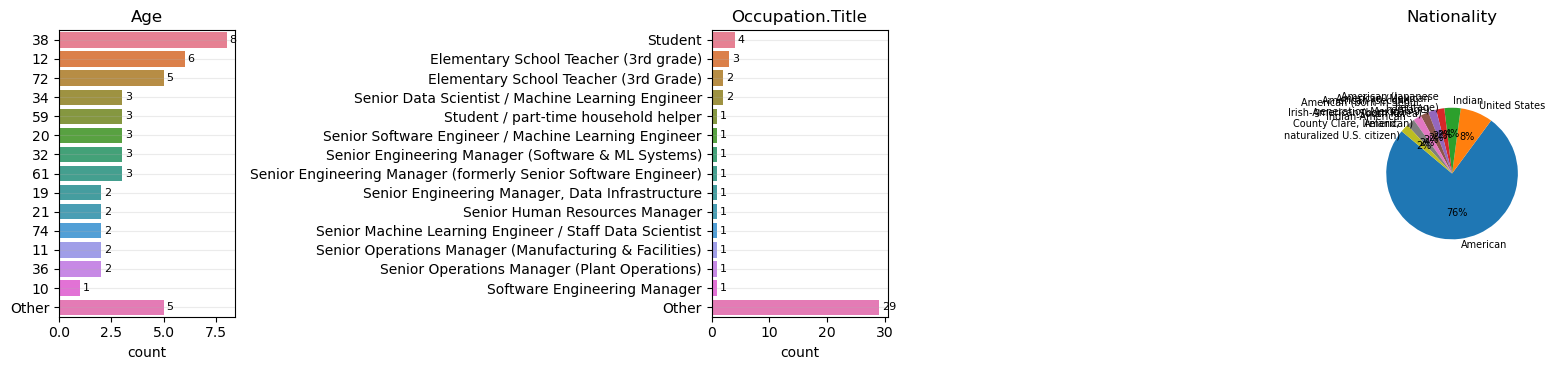

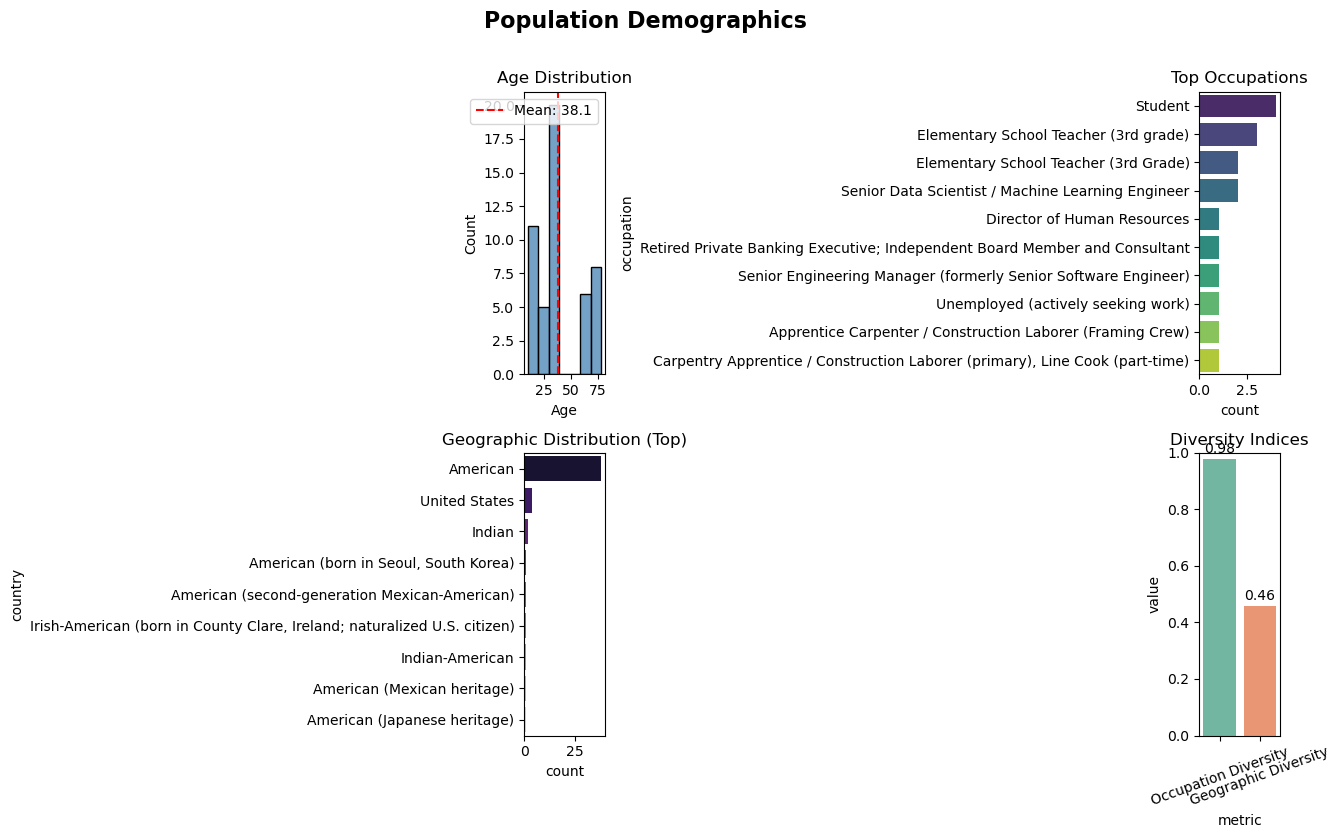

Persona composition keys found: ['interests', 'skills', 'beliefs', 'goals', 'likes_dislikes', 'routines', 'relationship_roles', 'communication_style', 'health', 'personality_traits']
[DEBUG persona_plot] facet 'interests' empty -> hidden
[DEBUG persona_plot] facet 'goals' empty -> hidden
[DEBUG persona_plot] facet 'likes_dislikes' empty -> hidden
[DEBUG persona_plot] facet 'relationship_roles' empty -> hidden
[DEBUG persona_plot] facet 'health' empty -> hidden


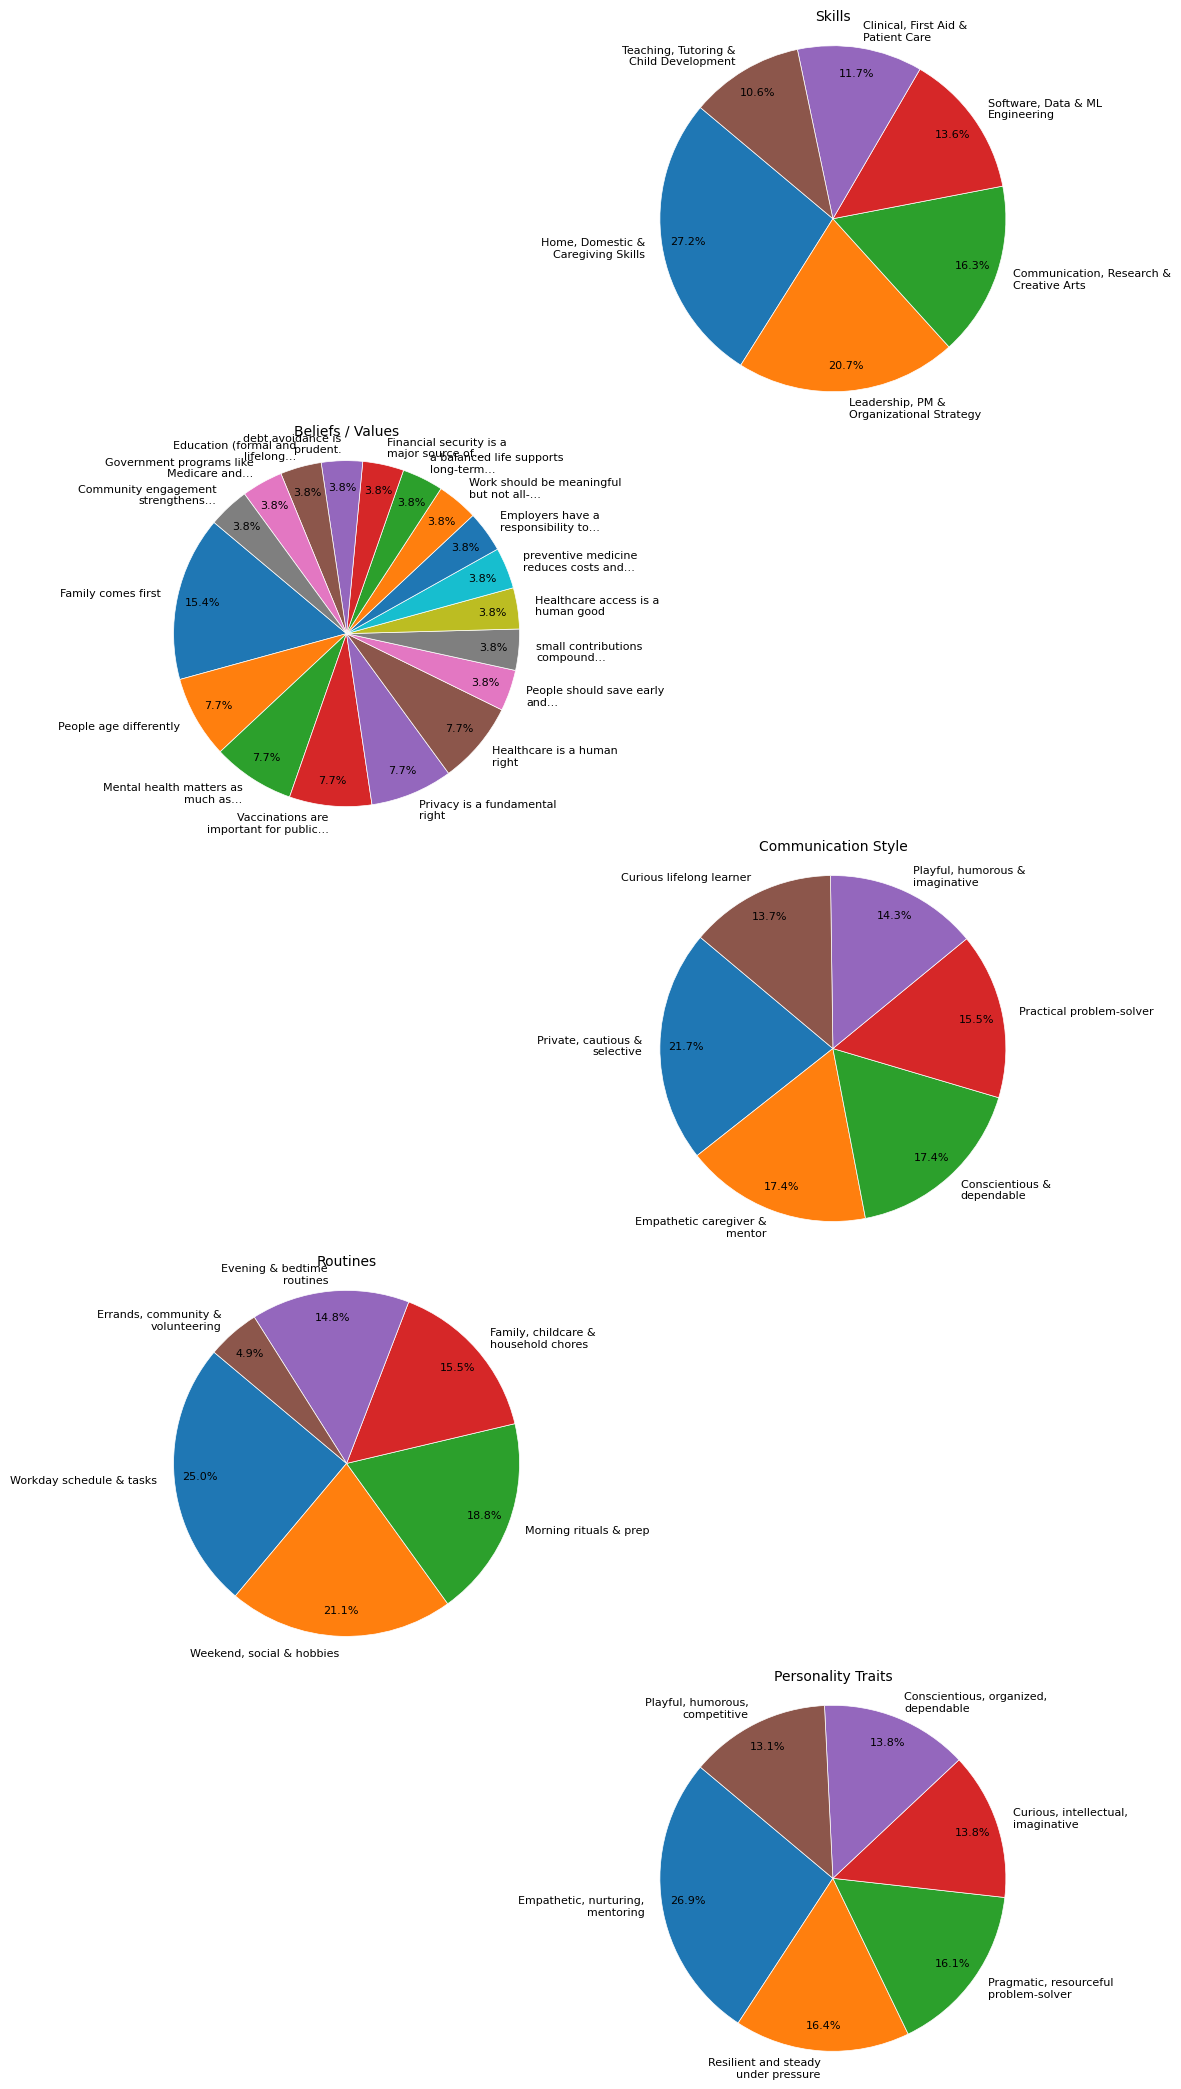

{'age': 10    1
 11    2
 12    6
 19    2
 20    3
 21    2
 31    1
 32    3
 33    1
 34    3
 36    2
 37    1
 38    8
 39    1
 59    3
 61    3
 72    5
 74    2
 78    1
 Name: count, dtype: int64,
 'occupation.title': Apprentice Carpenter / Construction Laborer (Framing Crew)                                                             1
 Carpentry Apprentice / Construction Laborer (primary), Line Cook (part-time)                                           1
 Certified Nursing Assistant (CNA) / Healthcare Support                                                                 1
 Certified Nursing Assistant (CNA) / Healthcare Support Worker                                                          1
 Currently unemployed; seeking administrative/office or bookkeeping work                                                1
 Director of Human Resources                                                                                            1
 Elementary School Teacher (3rd Grade)    

In [13]:
profiler = Profiler()
profiler.profile(people)

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [14]:
#control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [15]:
market = TinyWorld(f"Target audience ({target_nationality})", people, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [16]:
market.broadcast(interviewer_introduction)
market.broadcast(interviewer_main_question)
market.broadcast_thought(inner_monologue)

USER --> Catherine Elizabeth Montrose: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please present yourself and also list your top-10 interests?

       + --> Laura Bethany Palmer

       + --> Vivian Alexandra Blackwell

       + --> ...others...

USER --> Catherine Elizabeth Montrose: [CONVERSATION] 
          >       Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with
          > tomatoes, cucumbers, peppers, and olive oil.      We are considering offering it in
          > supermarkets near you.      Would you consider purchasing ready-to-drink bottled
          > gazpacho if it was available at your local supermarket? How much do you like this idea?
          > Please rate your propensity of purchasing it (from 1 to 5), where:        - 1: would
          > NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how
          > you feel, as it is part of the human experience.        - 2: very unlikely, but not
          > impossible.        - 3: maybe I would buy it, not sure.        - 4: it is very likely.
          > - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive
          > answer if it is how you feel, as it is part of the human experience.          Please
          > just give your number and justification, and then you are done. Giving a number helps us
          > compile the data, so use it please.

       + --> Laura Bethany Palmer

       + --> Vivian Alexandra Blackwell

       + --> ...others...

Catherine Elizabeth Montrose --> Catherine Elizabeth Montrose: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.      My answer will be something like "My propensity is
                                  > X, because ...", always stating the propensity score and
                                  > justifying it later.

Laura Bethany Palmer --> Laura Bethany Palmer: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.
                          > My answer will be something like "My propensity is X, because ...",
                          > always stating the propensity score and justifying it later.

Vivian Alexandra Blackwell --> Vivian Alexandra Blackwell: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.      My
                                > answer will be something like "My propensity is X, because ...",
                                > always stating the propensity score and justifying it later.

Daniel Marcus Everett --> Daniel Marcus Everett: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.      My answer will be something like "My propensity is X,
                           > because ...", always stating the propensity score and justifying it
                           > later.

Susan Elaine Carter --> Susan Elaine Carter: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.
                         > My answer will be something like "My propensity is X, because ...",
                         > always stating the propensity score and justifying it later.

Michelle Donovan --> Michelle Donovan: [THOUGHT] 
                      >      I will be honest as I understand they are not here to judge me, but
                      > just to learn from me.      Such choices depend on many factors, but I will
                      > make my best guess, considering my current      situation in life, location,
                      > job and interests. I will not refrain from giving extreme answers,      such
                      > as 1 or 5, if that's how I really feel, as this exercise requires me to be
                      > honest, human and realistic.      Now I **must** first THINK deeply about
                      > the question, consider all the factors that might influence my decision,
                      > and only then I will TALK with my response to the question as best, as
                      > detailed and as honestly as I can.      My answer will be something like "My
                      > propensity is X, because ...", always stating the propensity score and
                      > justifying it later.

Colton James Mercer --> Colton James Mercer: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.
                         > My answer will be something like "My propensity is X, because ...",
                         > always stating the propensity score and justifying it later.

Mason Eli Calloway --> Mason Eli Calloway: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.
                        > My answer will be something like "My propensity is X, because ...", always
                        > stating the propensity score and justifying it later.

Naomi Elise Brooks --> Naomi Elise Brooks: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.
                        > My answer will be something like "My propensity is X, because ...", always
                        > stating the propensity score and justifying it later.

Ananya Reema Kapoor --> Ananya Reema Kapoor: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.
                         > My answer will be something like "My propensity is X, because ...",
                         > always stating the propensity score and justifying it later.

Alexander Pierce --> Alexander Pierce: [THOUGHT] 
                      >      I will be honest as I understand they are not here to judge me, but
                      > just to learn from me.      Such choices depend on many factors, but I will
                      > make my best guess, considering my current      situation in life, location,
                      > job and interests. I will not refrain from giving extreme answers,      such
                      > as 1 or 5, if that's how I really feel, as this exercise requires me to be
                      > honest, human and realistic.      Now I **must** first THINK deeply about
                      > the question, consider all the factors that might influence my decision,
                      > and only then I will TALK with my response to the question as best, as
                      > detailed and as honestly as I can.      My answer will be something like "My
                      > propensity is X, because ...", always stating the propensity score and
                      > justifying it later.

Noah Benjamin Harrington --> Noah Benjamin Harrington: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.      My answer will be something like "My
                              > propensity is X, because ...", always stating the propensity score
                              > and justifying it later.

Eleanor Beatrice Kensington --> Eleanor Beatrice Kensington: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.      My answer will be something like "My propensity is X,
                                 > because ...", always stating the propensity score and justifying
                                 > it later.

Lucas Minho Kim --> Lucas Minho Kim: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests. I will not refrain from giving extreme answers,      such as 1
                     > or 5, if that's how I really feel, as this exercise requires me to be honest,
                     > human and realistic.      Now I **must** first THINK deeply about the
                     > question, consider all the factors that might influence my decision,     and
                     > only then I will TALK with my response to the question as best, as detailed
                     > and as honestly as I can.      My answer will be something like "My
                     > propensity is X, because ...", always stating the propensity score and
                     > justifying it later.

Marisol Vega --> Marisol Vega: [THOUGHT] 
                  >      I will be honest as I understand they are not here to judge me, but just to
                  > learn from me.      Such choices depend on many factors, but I will make my best
                  > guess, considering my current      situation in life, location, job and
                  > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                  > if that's how I really feel, as this exercise requires me to be honest, human
                  > and realistic.      Now I **must** first THINK deeply about the question,
                  > consider all the factors that might influence my decision,     and only then I
                  > will TALK with my response to the question as best, as detailed and as honestly
                  > as I can.      My answer will be something like "My propensity is X, because
                  > ...", always stating the propensity score and justifying it later.

Lena Harper --> Lena Harper: [THOUGHT] 
                 >      I will be honest as I understand they are not here to judge me, but just to
                 > learn from me.      Such choices depend on many factors, but I will make my best
                 > guess, considering my current      situation in life, location, job and
                 > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                 > if that's how I really feel, as this exercise requires me to be honest, human and
                 > realistic.      Now I **must** first THINK deeply about the question, consider
                 > all the factors that might influence my decision,     and only then I will TALK
                 > with my response to the question as best, as detailed and as honestly as I can.
                 > My answer will be something like "My propensity is X, because ...", always
                 > stating the propensity score and justifying it later.

Mateo Cruz --> Mateo Cruz: [THOUGHT] 
                >      I will be honest as I understand they are not here to judge me, but just to
                > learn from me.      Such choices depend on many factors, but I will make my best
                > guess, considering my current      situation in life, location, job and interests.
                > I will not refrain from giving extreme answers,      such as 1 or 5, if that's how
                > I really feel, as this exercise requires me to be honest, human and realistic.
                > Now I **must** first THINK deeply about the question, consider all the factors
                > that might influence my decision,     and only then I will TALK with my response
                > to the question as best, as detailed and as honestly as I can.      My answer will
                > be something like "My propensity is X, because ...", always stating the propensity
                > score and justifying it later.

Lucia Isabel Ramirez --> Lucia Isabel Ramirez: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.
                          > My answer will be something like "My propensity is X, because ...",
                          > always stating the propensity score and justifying it later.

Patricia Lorraine Keller --> Patricia Lorraine Keller: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.      My answer will be something like "My
                              > propensity is X, because ...", always stating the propensity score
                              > and justifying it later.

Taylor Montgomery Wells --> Taylor Montgomery Wells: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.      My answer will be something like "My
                             > propensity is X, because ...", always stating the propensity score
                             > and justifying it later.

Maisie Grace Holloway --> Maisie Grace Holloway: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.      My answer will be something like "My propensity is X,
                           > because ...", always stating the propensity score and justifying it
                           > later.

Thomas Gregory Langford --> Thomas Gregory Langford: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.      My answer will be something like "My
                             > propensity is X, because ...", always stating the propensity score
                             > and justifying it later.

Eileen Margaret O'Connor --> Eileen Margaret O'Connor: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.      My answer will be something like "My
                              > propensity is X, because ...", always stating the propensity score
                              > and justifying it later.

Priya Meera Shah --> Priya Meera Shah: [THOUGHT] 
                      >      I will be honest as I understand they are not here to judge me, but
                      > just to learn from me.      Such choices depend on many factors, but I will
                      > make my best guess, considering my current      situation in life, location,
                      > job and interests. I will not refrain from giving extreme answers,      such
                      > as 1 or 5, if that's how I really feel, as this exercise requires me to be
                      > honest, human and realistic.      Now I **must** first THINK deeply about
                      > the question, consider all the factors that might influence my decision,
                      > and only then I will TALK with my response to the question as best, as
                      > detailed and as honestly as I can.      My answer will be something like "My
                      > propensity is X, because ...", always stating the propensity score and
                      > justifying it later.

Samantha Rivera --> Samantha Rivera: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests. I will not refrain from giving extreme answers,      such as 1
                     > or 5, if that's how I really feel, as this exercise requires me to be honest,
                     > human and realistic.      Now I **must** first THINK deeply about the
                     > question, consider all the factors that might influence my decision,     and
                     > only then I will TALK with my response to the question as best, as detailed
                     > and as honestly as I can.      My answer will be something like "My
                     > propensity is X, because ...", always stating the propensity score and
                     > justifying it later.

Sofia Morales --> Sofia Morales: [THOUGHT] 
                   >      I will be honest as I understand they are not here to judge me, but just
                   > to learn from me.      Such choices depend on many factors, but I will make my
                   > best guess, considering my current      situation in life, location, job and
                   > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                   > if that's how I really feel, as this exercise requires me to be honest, human
                   > and realistic.      Now I **must** first THINK deeply about the question,
                   > consider all the factors that might influence my decision,     and only then I
                   > will TALK with my response to the question as best, as detailed and as honestly
                   > as I can.      My answer will be something like "My propensity is X, because
                   > ...", always stating the propensity score and justifying it later.

Mariana Castillo --> Mariana Castillo: [THOUGHT] 
                      >      I will be honest as I understand they are not here to judge me, but
                      > just to learn from me.      Such choices depend on many factors, but I will
                      > make my best guess, considering my current      situation in life, location,
                      > job and interests. I will not refrain from giving extreme answers,      such
                      > as 1 or 5, if that's how I really feel, as this exercise requires me to be
                      > honest, human and realistic.      Now I **must** first THINK deeply about
                      > the question, consider all the factors that might influence my decision,
                      > and only then I will TALK with my response to the question as best, as
                      > detailed and as honestly as I can.      My answer will be something like "My
                      > propensity is X, because ...", always stating the propensity score and
                      > justifying it later.

Caroline Mendoza-Reed --> Caroline Mendoza-Reed: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.      My answer will be something like "My propensity is X,
                           > because ...", always stating the propensity score and justifying it
                           > later.

Malik Thompson --> Malik Thompson: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.      My answer will be something like "My propensity
                    > is X, because ...", always stating the propensity score and justifying it
                    > later.

Evan Haruki Nakamura --> Evan Haruki Nakamura: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.
                          > My answer will be something like "My propensity is X, because ...",
                          > always stating the propensity score and justifying it later.

Edward Sterling Whitmore --> Edward Sterling Whitmore: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.      My answer will be something like "My
                              > propensity is X, because ...", always stating the propensity score
                              > and justifying it later.

Hannah Cooper --> Hannah Cooper: [THOUGHT] 
                   >      I will be honest as I understand they are not here to judge me, but just
                   > to learn from me.      Such choices depend on many factors, but I will make my
                   > best guess, considering my current      situation in life, location, job and
                   > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                   > if that's how I really feel, as this exercise requires me to be honest, human
                   > and realistic.      Now I **must** first THINK deeply about the question,
                   > consider all the factors that might influence my decision,     and only then I
                   > will TALK with my response to the question as best, as detailed and as honestly
                   > as I can.      My answer will be something like "My propensity is X, because
                   > ...", always stating the propensity score and justifying it later.

Heather Lawson --> Heather Lawson: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.      My answer will be something like "My propensity
                    > is X, because ...", always stating the propensity score and justifying it
                    > later.

Margaret Ann Pembroke --> Margaret Ann Pembroke: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.      My answer will be something like "My propensity is X,
                           > because ...", always stating the propensity score and justifying it
                           > later.

Elizabeth Worthington --> Elizabeth Worthington: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.      My answer will be something like "My propensity is X,
                           > because ...", always stating the propensity score and justifying it
                           > later.

Mateo Javier Alvarez --> Mateo Javier Alvarez: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.
                          > My answer will be something like "My propensity is X, because ...",
                          > always stating the propensity score and justifying it later.

Kai Emerson Brooks --> Kai Emerson Brooks: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.
                        > My answer will be something like "My propensity is X, because ...", always
                        > stating the propensity score and justifying it later.

Quinn Sinclair --> Quinn Sinclair: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.      My answer will be something like "My propensity
                    > is X, because ...", always stating the propensity score and justifying it
                    > later.

Erin Walker --> Erin Walker: [THOUGHT] 
                 >      I will be honest as I understand they are not here to judge me, but just to
                 > learn from me.      Such choices depend on many factors, but I will make my best
                 > guess, considering my current      situation in life, location, job and
                 > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                 > if that's how I really feel, as this exercise requires me to be honest, human and
                 > realistic.      Now I **must** first THINK deeply about the question, consider
                 > all the factors that might influence my decision,     and only then I will TALK
                 > with my response to the question as best, as detailed and as honestly as I can.
                 > My answer will be something like "My propensity is X, because ...", always
                 > stating the propensity score and justifying it later.

Jordan Alvarez --> Jordan Alvarez: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.      My answer will be something like "My propensity
                    > is X, because ...", always stating the propensity score and justifying it
                    > later.

Deborah Lynn Hayes --> Deborah Lynn Hayes: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.
                        > My answer will be something like "My propensity is X, because ...", always
                        > stating the propensity score and justifying it later.

Avery Morales-Johnson --> Avery Morales-Johnson: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.      My answer will be something like "My propensity is X,
                           > because ...", always stating the propensity score and justifying it
                           > later.

Richard Langley --> Richard Langley: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests. I will not refrain from giving extreme answers,      such as 1
                     > or 5, if that's how I really feel, as this exercise requires me to be honest,
                     > human and realistic.      Now I **must** first THINK deeply about the
                     > question, consider all the factors that might influence my decision,     and
                     > only then I will TALK with my response to the question as best, as detailed
                     > and as honestly as I can.      My answer will be something like "My
                     > propensity is X, because ...", always stating the propensity score and
                     > justifying it later.

Riley Bennett --> Riley Bennett: [THOUGHT] 
                   >      I will be honest as I understand they are not here to judge me, but just
                   > to learn from me.      Such choices depend on many factors, but I will make my
                   > best guess, considering my current      situation in life, location, job and
                   > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                   > if that's how I really feel, as this exercise requires me to be honest, human
                   > and realistic.      Now I **must** first THINK deeply about the question,
                   > consider all the factors that might influence my decision,     and only then I
                   > will TALK with my response to the question as best, as detailed and as honestly
                   > as I can.      My answer will be something like "My propensity is X, because
                   > ...", always stating the propensity score and justifying it later.

Arjun Malhotra --> Arjun Malhotra: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.      My answer will be something like "My propensity
                    > is X, because ...", always stating the propensity score and justifying it
                    > later.

Amelia Torres --> Amelia Torres: [THOUGHT] 
                   >      I will be honest as I understand they are not here to judge me, but just
                   > to learn from me.      Such choices depend on many factors, but I will make my
                   > best guess, considering my current      situation in life, location, job and
                   > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                   > if that's how I really feel, as this exercise requires me to be honest, human
                   > and realistic.      Now I **must** first THINK deeply about the question,
                   > consider all the factors that might influence my decision,     and only then I
                   > will TALK with my response to the question as best, as detailed and as honestly
                   > as I can.      My answer will be something like "My propensity is X, because
                   > ...", always stating the propensity score and justifying it later.

Dorothy Mae Harris --> Dorothy Mae Harris: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.
                        > My answer will be something like "My propensity is X, because ...", always
                        > stating the propensity score and justifying it later.

Evelyn Joyce Mitchell --> Evelyn Joyce Mitchell: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.      My answer will be something like "My propensity is X,
                           > because ...", always stating the propensity score and justifying it
                           > later.

Maya Thompson-Rodriguez --> Maya Thompson-Rodriguez: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.      My answer will be something like "My
                             > propensity is X, because ...", always stating the propensity score
                             > and justifying it later.

Rowan Carter --> Rowan Carter: [THOUGHT] 
                  >      I will be honest as I understand they are not here to judge me, but just to
                  > learn from me.      Such choices depend on many factors, but I will make my best
                  > guess, considering my current      situation in life, location, job and
                  > interests. I will not refrain from giving extreme answers,      such as 1 or 5,
                  > if that's how I really feel, as this exercise requires me to be honest, human
                  > and realistic.      Now I **must** first THINK deeply about the question,
                  > consider all the factors that might influence my decision,     and only then I
                  > will TALK with my response to the question as best, as detailed and as honestly
                  > as I can.      My answer will be something like "My propensity is X, because
                  > ...", always stating the propensity score and justifying it later.

In [17]:
market.run(1)

2025-10-02 12:07:41,680 - tinytroupe - INFO - [Target audience (American)] Running world simulation step 1 of 1.


───────────────────────────────────── Target audience (American) step 1 of 1 ──────────────────────────────────────

2025-10-02 12:07:41,686 - tinytroupe - INFO - [Target audience (American)] No timedelta provided, so the datetime was not advanced.
2025-10-02 12:08:06,654 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Noah Benjamin Harrington acts: [THINK] 
                              > Step through the factors before answering: 1) Personal taste: I like
                              > vegetable-forward dishes and fresh flavors, but I generally prefer
                              > minimally processed, high-quality ingredients. 2) Use case: A
                              > bottled gazpacho would be convenience lunch/snack on warm days or
                              > something to bring on a short outing; not a family dinner item with
                              > a toddler. 3) Seasonality: More appealing in summer; less in cooler
                              > months. 4) Brand/quality signals: I'd buy if it's from a
                              > local/transparent maker, low on additives, reasonable sodium, good
                              > texture (not watered down). 5) Packaging & sustainability: I care
                              > about waste — recyclable or reusable packaging helps. 6) Price &
                              > availability: Needs to be competitive with making a quick fresh
                              > version or buying from a good deli. 7) Probability of trial: I'm
                              > willing to try new food products if the packaging/signals are right.
                              > Balancing these, my baseline is neutral-to-moderately open. I'll
                              > state a clear propensity and justify it succinctly.

Noah Benjamin Harrington acts: [TALK] 
                              > My propensity is 3. I might buy ready-to-drink bottled gazpacho, but
                              > it depends on a few things: (a) quality — it needs to taste fresh
                              > (good tomato/pepper balance) and not be overly salty or thin; (b)
                              > provenance/transparency — I prefer local or clearly labeled
                              > ingredients; (c) seasonality and price — I'd be more likely to buy
                              > it in summer at a reasonable price versus year-round at a premium;
                              > and (d) sustainable packaging. If those conditions are met, I’d try
                              > it occasionally as a convenient, veggie-forward lunch or picnic
                              > item. If it feels overly processed or expensive, I wouldn’t become a
                              > regular buyer.

Noah Benjamin Harrington acts: [DONE] 
                              > Waiting for follow-up (e.g., preferred price point or packaging
                              > options).

2025-10-02 12:08:07,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Naomi Elise Brooks acts: [THINK] 
                        > Okay—I'll walk through this honestly, like I promised. Factors that matter
                        > to me: taste (I prefer fresh, bright vegetable flavors), health (mostly
                        > vegetarian, avoid heavily-processed foods), price (student budget),
                        > packaging and sustainability (I try to avoid single-use plastics), and
                        > seasonality/convenience (cold soups feel right in hot weather or as a
                        > quick, light meal). Also authenticity and ingredient list matter—if it
                        > tastes like a watered-down, salty convenience product, I won't buy it; if
                        > it's made by a trusted local producer or in glass with simple ingredients,
                        > I'm more likely to try it.  Now weigh those: I do like tomato-cucumber-
                        > pepper flavors and I've had good gazpacho at small eateries in Brooklyn,
                        > so the flavor profile appeals. But I also often make simple salads or
                        > blended soups at home because it's cheaper. On campus I might grab a
                        > bottled drink for convenience, but my budget and environmental values push
                        > me to be selective. So my honest, realistic propensity lands in the
                        > middle: I could see my (...)

Naomi Elise Brooks acts: [TALK] 
                        > My propensity is 3 — maybe I would buy it. I like the flavor idea (fresh
                        > tomatoes, cucumber, pepper) and as a vegetarian the product fits my diet,
                        > but my decision depends on price, ingredients, and packaging. If it's
                        > affordably priced, made with simple, fresh ingredients (no weird
                        > stabilizers), sold in glass or recyclable packaging, or made by a local
                        > co-op or small producer I trust, I'd pick one up on a hot day or between
                        > classes. If it's expensive, overly salty or sugary, in single-use plastic,
                        > or feels like a mass-market convenience product, I'm unlikely to buy it.

Naomi Elise Brooks acts: [DONE] 
                        > Finished answering the thought; waiting for next prompt.

2025-10-02 12:08:08,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ananya Reema Kapoor acts: [THINK] 
                         > Okay — I will weigh the factors that matter to me when buying a ready-to-
                         > drink savoury product. Factors: (1) Taste fit: I generally like
                         > Mediterranean flavours and plant-forward dishes, so a fresh tomato-
                         > cucumber-pepper soup is appealing. (2) Freshness & ingredients: I prefer
                         > minimal processing, transparent ingredient lists, low sugar/salt, and
                         > real-vegetable flavour — otherwise I won't buy. (3) Convenience &
                         > occasions: I might buy chilled bottled gazpacho for a hot day, as a light
                         > lunch with bread/cheese, or as a picnic item — so convenience matters.
                         > (4) Packaging & sustainability: glass or recyclable packaging and honest
                         > sourcing would increase my propensity; single-use plastic or excessive
                         > packaging would decrease it. (5) Price & availability: it needs to be
                         > reasonably priced for a ready-to-eat premium product and available at my
                         > usual supermarket or local grocer. (6) Health/diet: as a flexitarian who
                         > eats mostly plant-forward, a vegetable soup aligns well. Balancing all
                         > this, I’d be open to buying it regu (...)

Ananya Reema Kapoor acts: [TALK] 
                         > My propensity is 4. I would very likely buy a ready-to-drink bottled
                         > gazpacho if it tastes fresh (real tomato/cucumber/pepper flavour), has a
                         > short, transparent ingredient list (no odd preservatives or added sugar),
                         > comes in recyclable/glass packaging, and is priced reasonably. It fits my
                         > plant-forward preferences and would be a convenient light meal on hot
                         > days or for picnics. I’d be less likely (1–2) if it tastes overly
                         > processed, uses plastic-heavy packaging, or has a long list of artificial
                         > additives.

Ananya Reema Kapoor acts: [DONE] 
                         > Response provided.

2025-10-02 12:08:11,515 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Mason Eli Calloway acts: [THINK] 
                        > Alright — I gotta be straight with this. Thinkin' about usual groceries
                        > around here: we mostly buy hearty, familiar stuff — coffee, canned beans,
                        > soup in winter, not much cold blended tomato juice as a meal.
                        > Considerations: I don't much care for cold vegetable soups, bottled ready-
                        > to-drink stuff feels pricey and fiddly, and around here folks favor local,
                        > hot comfort food. Also think about convenience and price on a limited
                        > budget, plus I like to try new things but only if it actually fills a meal
                        > or tastes good. I'm gonna pick a number that reflects my skepticism but
                        > leaves room for tryin' it once if there's a sample or cheap price.

Mason Eli Calloway acts: [TALK] 
                        > My propensity is 2. I reckon I'd be very unlikely to buy bottled gazpacho
                        > — not 'cause it ain't fine for some folks, but I prefer hot, hearty stuff
                        > and canned or bottled cold soups don't feel like a meal to me. Around here
                        > it's not common, I worry about price and preservatives, and I don't see it
                        > replacing a biscuit-and-gravy or a sandwich. That said, if it was cheap,
                        > local, or I could try a sample and it actually tasted good, I might pick
                        > one up once in a while.

Mason Eli Calloway acts: [DONE] 
                        > Finished answering the gazpacho question.

2025-10-02 12:08:12,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Daniel Marcus Everett acts: [THINK] 
                           > Weighing factors before answering: my food habits (I usually prep
                           > lunches at home), preferences (I like Mediterranean flavours and
                           > farmer's-market produce), family constraints (young son who won't eat
                           > something like gazpacho), seasonality (cold soups feel right in
                           > summer), and practical concerns (taste authenticity, refrigeration vs.
                           > shelf-stable, additives, price and packaging/sustainability). As a busy
                           > parent and manager I value convenience but not at the expense of
                           > obviously poor quality. So my acceptance depends on product attributes:
                           > refrigerated, real ingredients, reasonable price, and available
                           > locally. I'll give a single numeric propensity and a short
                           > justification.

Daniel Marcus Everett acts: [TALK] 
                           > My propensity is 3, because I'm open to buying ready-to-drink bottled
                           > gazpacho occasionally but only under conditions: it needs to taste
                           > fresh and use real vegetables (not overly processed or salty), be sold
                           > refrigerated (not a heavily preserved shelf-stable version), be
                           > reasonably priced for a single lunch/snack, and come in responsible
                           > packaging. If it meets those bars—good ingredient list, authentic
                           > flavour, and local availability—I'll buy it now and then (especially in
                           > summer or for a picnic). If it's mediocre or expensive, I probably
                           > won't.

Daniel Marcus Everett acts: [DONE] 
                           > Finished response.

2025-10-02 12:08:12,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Susan Elaine Carter acts: [THINK] 
                         > Well... I ought to think this through. Factors that matter to me: taste
                         > (I like tomatoes and basil), price (I watch sales and coupons),
                         > seasonality (I'd prefer something summery), ingredient list (no weird
                         > additives), convenience (single-serve or a family bottle I can stretch),
                         > and whether it feels like a passing food fad or something practical. Also
                         > whether I'd make it myself — I do some canning and fresh tomato salads in
                         > summer, so a bottled version would need to be noticeably convenient or
                         > cheaper than buying fresh tomatoes. I'll give a single-number propensity
                         > and then explain the reasons plainly.

Susan Elaine Carter acts: [TALK] 
                         > My propensity is 3. Maybe I'd buy it, not sure. I like the basic
                         > ingredients — tomatoes, cucumber, peppers — and it sounds healthy,
                         > especially in hot weather, so I'd be willing to try a small bottle if it
                         > was affordable and tasted fresh. On the other hand I'm skeptical of
                         > trendy, expensive bottled items with long ingredient lists or lots of
                         > preservatives. So if the supermarket sold a simple, reasonably priced
                         > brand (or it was on sale), I'd pick one up in summer. If it's marketed as
                         > a pricey gourmet thing or sits under an unfamiliar label, I'd probably
                         > pass.

Susan Elaine Carter acts: [DONE] 
                         > Answered the market-research question.

2025-10-02 12:08:13,513 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Alexander Pierce acts: [THINK] 
                      > I should consider the practical factors before I state a number:
                      > taste/texture (gazpacho should taste fresh, not metallic or overly sweet),
                      > ingredient list and sodium, packaging and cold-chain integrity, price per
                      > serving, convenience for a quick lunch or post-run snack, and sustainability
                      > of the bottle. Also weigh personal habits: I like seasonal vegetables and
                      > cooking from scratch, but I buy convenient, healthy items occasionally when
                      > they save time. Family context matters a little — Noah might not love a cold
                      > tomato soup, so a single-serve option that I can bring for myself is
                      > preferable. If a product looks like a deli-quality gazpacho (short
                      > ingredient list, no weird preservatives) and the price is reasonable, I'm
                      > more likely to try it. If it tastes flat or is heavily processed, I won't
                      > repurchase. Overall the decision is a tradeoff between freshness (which I
                      > prefer) and convenience (which I sometimes accept).

Alexander Pierce acts: [TALK] 
                      > My propensity is 3, because I like the idea of a vegetable-forward, ready-
                      > to-drink option for hot days or a quick, healthy lunch, but I usually prefer
                      > fresh-made or deli versions. I would try a bottled gazpacho if the
                      > ingredient list looked clean (real tomatoes, cucumbers, peppers, olive oil),
                      > sodium and preservatives were minimal, the price per serving was reasonable,
                      > and the packaging was recyclable or reusable. If it tasted processed or
                      > overly sweet/salty, I wouldn't repurchase. So: maybe — I'll buy it under the
                      > right quality and sustainability conditions.

Alexander Pierce acts: [DONE] 
                      > Answered the prompt and waiting for any follow-up questions.

2025-10-02 12:08:15,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Vivian Alexandra Blackwell acts: [THINK] 
                                > I should weigh the factors a sensible consumer of my profile would
                                > consider. Relevant points: my dietary preference is largely
                                > Mediterranean and plant-forward, so a vegetable-based cold soup
                                > aligns with my tastes. I care about provenance, ingredient
                                > quality, and modest portioning; I dislike overly processed, high-
                                > sodium products. Convenience matters sometimes — for a light
                                > summer lunch, a well-made bottled gazpacho could be appealing when
                                > I do not have time to prepare my own. Packaging matters: I prefer
                                > glass or recyclable materials and dislike single-use plastics.
                                > Price sensitivity: I will pay a modest premium for artisanal or
                                > local producers, less so for mass-market versions. Occasions: I
                                > might buy it for myself on a warm day, for a picnic, or as a
                                > starter when hosting informally, but I am unlikely to substitute
                                > it for regular cooking. Environmental and health concerns (low
                                > additives, reasonable sodium) will influence my choice. On balance
                                > these considerations suggest a middling-but-open propensity rather
                                > t (...)

Vivian Alexandra Blackwell acts: [TALK] 
                                > My propensity is 3, because I like the idea of a vegetable-
                                > forward, chilled soup — it fits my Mediterranean-leaning diet and
                                > would be pleasant on a warm day — but I would be selective. I
                                > would purchase ready-to-drink bottled gazpacho only if it met a
                                > few conditions: clear, simple ingredients (ripe tomatoes,
                                > cucumber, pepper, olive oil, vinegar), modest sodium, minimal
                                > preservatives, and thoughtful packaging (preferably glass or
                                > clearly recyclable). I would also be more inclined to buy a local
                                > or artisanal brand at a modest premium than a mass-produced,
                                > overly processed variety. If those quality and sustainability
                                > conditions were met, I might buy it occasionally; otherwise I
                                > would more likely make a small batch at home.

Vivian Alexandra Blackwell acts: [DONE] 
                                > Waiting for any follow-up questions about preferences or product
                                > attributes.

2025-10-02 12:08:15,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Colton James Mercer acts: [THINK] 
                         > Alright — gotta be straight about this. Figure in taste, price, how
                         > filling it is, and whether it'd even fit my usual meals. I eat simple,
                         > hearty stuff most days — bacon, eggs, sandwiches, meat and potatoes — and
                         > I don't tend to spend extra on fancy bottled stuff. Gazpacho is a cold
                         > tomato/veggie soup from Spain; on a hot summer day it might be nice, but
                         > I worry a bottle won't be filling, could be overpriced, and I don't know
                         > if I'd like the flavor. Also, I'm tight on cash some months, so
                         > convenience has to be worth the cost. I might try one once if it was
                         > cheap or free, but I wouldn't make it a regular buy. So leaning toward
                         > 'very unlikely' overall, with a small chance of a one-off try in summer.

Colton James Mercer acts: [TALK] 
                         > My propensity is 2 — very unlikely. I'm not big on cold, veggie-forward,
                         > ready-to-drink soups as a regular thing. Between taste (not sure I'd like
                         > a bottled tomato-veg soup), how filling it is (probably not much), and
                         > the price (I'd rather spend a few bucks on something more substantial),
                         > it doesn't fit my usual shopping. If it was cheap and it was a hot day,
                         > I'd maybe try one once, but I wouldn't buy it often.

Colton James Mercer acts: [DONE] 
                         > Answered the gazpacho question honestly and clearly.

2025-10-02 12:08:15,601 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Michelle Donovan acts: [THINK] 
                      > I'll be honest and weigh practical factors: I love fresh, seasonal foods and
                      > usually buy produce at the farmers' market. I prefer minimally processed
                      > items and am wary of preservatives and high sodium. Convenience matters
                      > sometimes — between teaching and family life, a ready-to-drink option could
                      > be useful on hot days or for picnics. Kids might not drink a vegetable soup,
                      > so household uptake would be limited unless it’s mild and tasty. Price and
                      > packaging (refrigerated, glass or recyclable, clear ingredient list, local
                      > sourcing) would influence me strongly. If the product tastes fresh and lists
                      > simple, local ingredients, I'd be more likely to try it. On balance, given
                      > my food values and family context, I lean toward a cautious maybe.

Michelle Donovan acts: [TALK] 
                      > My propensity is 3, because I might buy a ready-to-drink bottled gazpacho
                      > but only under the right conditions. I like the idea for hot summer days,
                      > road-trip picnics, or as a quick, veggie-forward lunch, but I prefer fresh,
                      > local, and minimally processed foods. I'd be more likely to buy it if it
                      > were refrigerated, made with simple/recognizable ingredients (no weird
                      > preservatives), reasonably low in sodium, and ideally from a local or small
                      > producer. Packaging that’s recyclable or glass would help. Price matters —
                      > it should be competitive with a simple deli soup. With those qualities, I’d
                      > probably try it once or twice that season; otherwise it’s unlikely to become
                      > a regular buy for our family.

Michelle Donovan acts: [DONE] 
                      > Finished response to the gazpacho question; waiting for any follow-ups.

2025-10-02 12:08:16,214 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Catherine Elizabeth Montrose acts: [THINK] 
                                  > I should weigh this honestly and practically. I like fresh,
                                  > vegetable-forward foods and follow a Mediterranean-ish eating
                                  > pattern, so the flavor profile of gazpacho appeals. On the other
                                  > hand I don't buy a lot of highly processed convenience foods —
                                  > ingredient quality, sodium level, seasonality, price, and
                                  > packaging will drive my decision. If it's a simple ingredient
                                  > list (real tomatoes, cucumbers, peppers, olive oil), reasonable
                                  > sodium, sold at a sensible single-serve price, and preferably
                                  > sold by a local or sustainably-minded brand, I'd be willing to
                                  > buy it in warm months. I'll give a single-number propensity and
                                  > a short justification.

Catherine Elizabeth Montrose acts: [TALK] 
                                  > My propensity is 4 (very likely). Because I enjoy fresh,
                                  > vegetable-based flavors and would welcome a ready-to-drink
                                  > gazpacho as a healthy, convenient lunch or snack in the summer.
                                  > I would buy it a few times during warm months if the ingredient
                                  > list is simple and recognisable (real tomatoes, cucumbers,
                                  > peppers, olive oil), the sodium isn't excessive, and the price
                                  > is reasonable (roughly $3.50–$5 for a single serving).
                                  > Sustainable packaging or a trusted local brand would make me
                                  > even more likely to pick it up; an overly processed taste, high
                                  > sodium, or strong, unnecessary heat would drop my interest to a
                                  > 2 or lower. Overall: a seasonal, practical purchase rather than
                                  > a year-round staple.

Catherine Elizabeth Montrose acts: [DONE] 
                                  > Finished answering the gazpacho propensity question.

2025-10-02 12:08:19,717 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Laura Bethany Palmer acts: [THINK] 
                          > Received my own prompt to be honest and deliberate. Okay — think step-
                          > by-step about buying ready-to-drink bottled gazpacho:  1) Personal
                          > cooking habits: I usually make soups and sauces from scratch when
                          > tomatoes are in season. Gazpacho is something I enjoy fresh on a hot day
                          > and I have a sourdough starter weekend ritual, so I prefer homemade when
                          > possible.  2) Convenience factor: School-year mornings and quick lunches
                          > sometimes push me toward convenient options. A chilled bottled gazpacho
                          > could be appealing as a quick, vegetable-forward lunch on hectic days or
                          > for a picnic after a hike.  3) Packaging and sustainability: I try to
                          > avoid single-use plastic. If the product is in a recyclable glass bottle
                          > or minimal, clearly recyclable packaging, I'm more open. A plastic
                          > single-serve bottle would lower my propensity.  4) Taste and
                          > ingredients: I care about olive oil, real vegetables, low added sugar,
                          > reasonable sodium, and not an overly processed flavor. I'd prefer a
                          > chunky, vegetal profile rather than a thin, ove (...)

Laura Bethany Palmer acts: [TALK] 
                          > My propensity is 2 — very unlikely, but not impossible. I usually make
                          > gazpacho from fresh summer tomatoes and prefer homemade flavors and
                          > texture. I try to avoid single-use plastic and processed-tasting
                          > products, so a mainstream bottled option would seldom make it into my
                          > cart. That said, I would consider an occasional purchase if it were a
                          > local, small-batch product in a recyclable glass bottle (or returnable
                          > container), with a fresh, olive-oil-forward profile, reasonable sodium,
                          > and an honest ingredient list — especially on a hot day or for a picnic.
                          > Price would need to be fair (roughly $3–$5 single-serve) for me to try
                          > it regularly.

Laura Bethany Palmer acts: [DONE] 
                          > Finished — answered the market-research question honestly.

2025-10-02 12:08:36,974 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Lucas Minho Kim acts: [THINK] 
                     > Weighing personal habits and preferences: I cook often and prefer fresh,
                     > minimally processed food, but I also value convenience for busy days.
                     > Consider seasonality (gazpacho feels like a summer item), packaging (I prefer
                     > glass or recyclable material), ingredient transparency (no weird
                     > stabilizers), and price point relative to making it at home. Also factor in
                     > sustainability and brand provenance — I'd be more likely to buy a locally
                     > made, well-labelled product than a mass-market, overly sweet bottled soup. I
                     > should give a concise propensity score and then justify it clearly.

Lucas Minho Kim acts: [TALK] 
                     > My propensity is 3, because I like the idea but it depends on execution. I’d
                     > maybe buy ready-to-drink gazpacho occasionally in summer if it’s from a local
                     > maker, uses obvious real ingredients (tomato, cucumber, pepper, olive oil,
                     > vinegar), comes in sustainable packaging (glass or recyclable), and isn’t
                     > loaded with salt or stabilizers. If it tastes fresh and is reasonably priced
                     > I’d grab it as a lunch or picnic option, but I’d skip cheap, overly sweet, or
                     > preservative-heavy versions — I usually make simple soups at home and prefer
                     > things that feel authentic rather than mass-produced.

Lucas Minho Kim acts: [DONE] 
                     > Finished — answered the market-research question honestly.

2025-10-02 12:08:39,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Maisie Grace Holloway acts: [THINK] 
                           > Okay, I need to be honest and think about this. I like tomato things—I
                           > like tomato sandwiches from the garden—so I might not hate something
                           > tomato-based. But I really don't like strong garlic or strange strong
                           > flavors. Gazpacho is cold and mixed veggies; cold is okay (I like iced
                           > lemonade) but bottled soups feel fancy and Mom usually buys our
                           > groceries, so price and whether Mom would buy it matters. Also I help
                           > in the garden and prefer fresh tomatoes to bottled stuff. If it tasted
                           > mild and didn't have a lot of garlic, and if it wasn't too expensive,
                           > I'd probably try a bottle. If it tasted strong or was pricey, we
                           > wouldn't buy it. So I'm leaning to a middle answer: maybe I'd buy it,
                           > not sure.

Maisie Grace Holloway acts: [TALK] 
                           > My propensity is 3, because I like tomato things so I'd try it, but I
                           > don't like strong garlic and Mom usually buys groceries. If the
                           > gazpacho tasted mild (not too garlicky), wasn't too expensive, and Mom
                           > said it was okay, then we might buy it. Otherwise I'd rather eat fresh
                           > tomatoes from our garden.

Maisie Grace Holloway acts: [DONE] 
                           > Answered the gazpacho question, waiting for next question.

2025-10-02 12:08:41,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thomas Gregory Langford acts: [THINK] 
                             > I need to weigh factors honestly: I like Mediterranean flavors and
                             > fresh vegetables, but I generally prefer home-cooked meals.
                             > Convenience matters on busy days, and seasonality (summer) makes a
                             > cold soup more appealing. Key concerns: perceived freshness,
                             > ingredient list (no weird preservatives), sodium level, whether it's
                             > refrigerated, texture (not too watery), and price. I'd be willing to
                             > sample a product in-store; a local or clearly high-quality brand
                             > would increase trust. Practical price expectation: under about $4 for
                             > a 12–16 oz bottle. Given my cautious, pragmatic nature, I won't
                             > commit to regular purchases without trying it and seeing
                             > nutrition/price. So my leaning is a neutral 'maybe' with conditions
                             > that would move it toward 'likely.'

Thomas Gregory Langford acts: [TALK] 
                             > My propensity is 3. I might buy it, but only under certain
                             > conditions: it tastes fresh (good tomato/veg flavor and texture), is
                             > sold refrigerated or clearly labeled for freshness, has a clean
                             > ingredient list and reasonable sodium, and is priced competitively
                             > (roughly <$4 for a single-serve bottle). I like the idea as a
                             > convenient summer lunch or appetizer, but I prefer home-made when I
                             > have time. Sampling in-store or positive local reviews would make me
                             > more likely to try and buy it occasionally; if it met all my
                             > conditions consistently, I could move to a 4.

Thomas Gregory Langford acts: [DONE] 
                             > Answered the market-research question and provided justification.

2025-10-02 12:08:42,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Marisol Vega acts: [THINK] 
                  > Okay—think through this honestly. Factors: my limited budget as a shift worker
                  > (price sensitivity), preference for homemade/real flavors, convenience needs
                  > after long shifts, storage/refrigeration at home, trust in brands/ingredient
                  > lists, seasonality (hot days make cold soup appealing), cultural fit (not a
                  > traditional Mexican staple but I like trying sensible, healthy options). If
                  > price is right and it tastes authentic, I'd try it; if it's expensive or tastes
                  > processed, I won't. I should answer with a single propensity number and justify
                  > it clearly.

Marisol Vega acts: [TALK] 
                  > My propensity is 3 — maybe I would buy it. I’d be curious and might try a
                  > bottled gazpacho for a few reasons: it’s refreshing on hot days, convenient
                  > after a long shift, and could be a healthier quick meal if the ingredient list
                  > looks real (tomato, cucumber, pepper, olive oil) and sodium isn’t too high. But
                  > I’m cautious: I prefer homemade flavors, distrust overly processed tastes, and I
                  > watch price closely. I’d be much more likely to buy it if it’s single-serve,
                  > reasonably priced (think closer to $2–3 on sale), has clear Spanish labeling or
                  > bilingual info, and tastes authentic without a lot of preservatives. If it’s
                  > expensive, sold only in specialty stores, or tastes artificial, I’d skip it. So:
                  > 3 — conditional interest, not a sure yes.

2025-10-02 12:08:42,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Marisol Vega acts: [DONE] 
                  > Finished answering the propensity question; waiting for next prompt.

Eleanor Beatrice Kensington acts: [THINK] 
                                 > Considerations: I value fresh, seasonal produce and prefer foods
                                 > prepared simply and locally. Ready-to-drink bottled items often
                                 > contain preservatives and higher sodium; I also dislike
                                 > unnecessary plastic packaging. Convenience in summer is a small
                                 > plus — I might accept a high-quality, locally produced bottled
                                 > gazpacho for a picnic or as an occasional convenience. On
                                 > balance, regular purchase is unlikely.

Eleanor Beatrice Kensington acts: [TALK] 
                                 > My propensity is 2. I am very unlikely to buy ready-to-drink
                                 > bottled gazpacho regularly. I prefer fresh, locally made or
                                 > homemade preparations — they taste better and allow me to control
                                 > salt and ingredients. I am also wary of preservatives and
                                 > unnecessary plastic packaging. That said, I might purchase an
                                 > artisanal bottled gazpacho once in a while in high summer if it
                                 > were from a trusted local producer and attractively packaged.

Eleanor Beatrice Kensington acts: [DONE] 
                                 > Waiting for further questions.

2025-10-02 12:08:43,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Lena Harper acts: [THINK] 
                 > Step through factors before answering. 1) Taste/freshness: Gazpacho shines when
                 > fresh; bottled versions can taste muted or plasticky if they rely on
                 > preservatives. 2) Convenience: I commute and like ready-to-eat, plant-forward
                 > options on hot days — that’s a plus. 3) Packaging/sustainability: I avoid single-
                 > use plastic when possible and prefer minimal, recyclable packaging or glass;
                 > wasteful packaging would be a dealbreaker. 4) Price & student budget: I’m price-
                 > sensitive — I’d try a sample but won’t pay a premium unless it’s clearly better
                 > than homemade or local vendor versions. 5) Ingredient/health transparency: I’d
                 > want short, recognizably fresh-vegetable ingredient lists and reasonable sodium.
                 > 6) Seasonality/occasion: I’d be more likely to buy in summer, for a picnic, or as
                 > a quick lunch substitute. Weighing those, I’m curious but skeptical — so I should
                 > give a cautious, middling propensity rather than an enthusiastic yes or a flat
                 > no.

Lena Harper acts: [TALK] 
                 > My propensity is 3, because I like the idea of a plant-forward, ready-to-eat cold
                 > soup for hot days and commuting, but I’d need reassurance on taste (freshness),
                 > clean ingredient lists, reasonable price, and sustainable packaging. If a
                 > supermarket offered a small-batch or glass-bottled version with transparent
                 > ingredients and a fair price, I’d buy it occasionally in summer; otherwise I’d
                 > probably pass or make my own.

Lena Harper acts: [DONE] 
                 > Finished response to the gazpacho question.

2025-10-02 12:08:44,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Patricia Lorraine Keller acts: [THINK] 
                              > I should be concise and honest. Factors to weigh: my liking for
                              > fresh tomatoes and Mediterranean-style foods; preference for
                              > minimally processed items; seasonality (gazpacho feels most
                              > appealing in summer); convenience vs. freshness trade-off;
                              > ingredient list (salt, preservatives, quality of olive oil);
                              > packaging (refrigerated glass preferred); price sensitivity —
                              > willing to pay a modest premium but not a lot; likelihood to buy for
                              > a summer lunch, a picnic, or when entertaining. I'll state a numeric
                              > propensity and then give a clear, practical justification with
                              > caveats.

Patricia Lorraine Keller acts: [TALK] 
                              > My propensity is 4, because I like Mediterranean flavors and late-
                              > summer tomatoes, so a good ready-to-drink gazpacho would appeal to
                              > me as a convenient, healthy summer option. I would buy it if it
                              > tasted fresh, listed simple ingredients (tomatoes, cucumbers,
                              > peppers, olive oil, vinegar, little added sugar), was reasonably low
                              > in sodium, and was sold refrigerated or in a trustworthy glass
                              > bottle. I prefer buying fresh at the farmers' market, so a bottled
                              > product would need to approximate that quality or come from a
                              > reputable local maker. Price matters — I’d pay a modest premium for
                              > quality, but not for something that tastes overly processed. In
                              > winter I’d be less likely to buy it, so most purchases would be
                              > seasonal.

2025-10-02 12:08:44,207 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Patricia Lorraine Keller acts: [DONE] 
                              > Response provided.

Eileen Margaret O'Connor acts: [THINK] 
                              > All right, I’ll think this through like I promised. Gazpacho — cold
                              > tomato soup from Spain. I do love soup, but mostly the warm, hearty
                              > sort: stews and boiled potatoes that fill you up on a blustery day.
                              > Summer’s a different matter — a cool dish can be pleasant on a hot
                              > afternoon on the stoop. I worry about added sugar and salt because
                              > of my diabetes and blood pressure, so I’d want to see a label I
                              > trust. Price matters: I’m careful with my pennies and I’d sooner
                              > make a small batch at home from tomatoes and cucumbers if it’s not
                              > too much bother. Also, I’m cautious of new packaged things unless
                              > I’ve tried a sample or a neighbour recommends it. If the supermarket
                              > sold a small, reasonably priced bottle and there was a taste test at
                              > the parish or market, I might try one in summer. But generally I
                              > prefer homemade or familiar foods. So I’m leaning towards unlikely,
                              > though not absolutely never.

Eileen Margaret O'Connor acts: [TALK] 
                              > My propensity is 2 — very unlikely. I’d sooner make my own chilled
                              > tomato soup in the summer than buy a ready-to-drink bottle. I’m
                              > careful with food because of my diabetes and hypertension, and I
                              > don’t trust newfangled packaged things unless I know the brand or
                              > can taste it first. It might be pleasant on a hot day and I’d try a
                              > small sample if offered, but I wouldn’t buy it regularly at the
                              > supermarket unless it was low in salt and sugar and reasonably
                              > priced. To be sure, a one-off in summer with a good label and a
                              > neighbour’s recommendation might change my mind, but as things stand
                              > I’d say 2.

Eileen Margaret O'Connor acts: [DONE] 
                              > Answered the question and waiting for next prompt.

2025-10-02 12:08:45,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Mateo Cruz acts: [THINK] 
                > Okay, think it through like Mateo. Factors to consider: 1) Taste/habits: I usually
                > like warm foods (tortillas, tacos) and snacks; I don't love cold soup or cold
                > cereal. Gazpacho is a cold blended veggie soup — not something I grew up with.  2)
                > Family budget: money is tight; we don't buy fancy ready-made drinks a lot. If it's
                > pricey, my mom won't buy it and I don't have much allowance.  3)
                > Convenience/novelty: I might try a small bottle once if it's cheap or a sample at
                > the store. If it was marketed like a snack and not expensive, maybe.  4)
                > Healthiness: veggies are good, so that helps a bit.  5) Culture/familiarity: it's
                > Spanish food but not the same as foods at home; could be interesting but not a
                > must-buy.  Conclusion: overall, I lean toward unlikely but not impossible. I'll
                > give a number and explain why, with one quick Spanglish note so it sounds like me.

Mateo Cruz acts: [TALK] 
                > My propensity is 2, because honestly I probably wouldn't buy bottled gazpacho a
                > lot. I like veggies and goûdos that are warm, and gazpacho is cold so it's not
                > exactly my favorite vibe. Also, money's tight at my house, so my mom won't spend
                > extra on a new bottled soup unless it's super cheap or on sale. I might try one if
                > there was a sample or a tiny bottle to see if I like it, or if my mom thought it
                > looked healthy for me and my hermana. Pero really, very unlikely — maybe once out
                > of curiosity, but not regular.

Mateo Cruz acts: [DONE] 
                > Answered the market-research question and waiting for next stimulus.

2025-10-02 12:08:46,922 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Priya Meera Shah acts: [THINK] 
                      > Weighing factors before answering: my food preferences (like fresh,
                      > authentic small-batch items), convenience needs, seasonality (cold soups
                      > feel right in summer), concerns about sodium/preservatives, packaging
                      > (prefer glass/local brands), and price. I should give a single propensity
                      > number and a short justification that reflects these trade-offs.

Priya Meera Shah acts: [TALK] 
                      > My propensity is 3, because I like the idea of gazpacho as a refreshing,
                      > vegetable-forward option and I try new foods, but I’d be cautious about
                      > ready-to-drink bottled versions. I’d buy one occasionally in summer or for a
                      > picnic if the ingredient list is clean, sodium is reasonable, it’s priced
                      > fairly (roughly $4–6 for a single-serving), and it comes in glass or
                      > recyclable packaging from a trusted/local brand. If it tastes overly
                      > processed or salty, I wouldn’t make it a regular purchase — I’d prefer
                      > fresh-from-a-cafe or homemade varieties.

Priya Meera Shah acts: [DONE] 
                      > Finished answer; waiting for any follow-up.

2025-10-02 12:08:52,933 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Lucia Isabel Ramirez acts: [THINK] 
                          > Okay, think through this carefully. Consider income and frugality — I
                          > watch prices and buy bulk or homemade when possible. Consider taste and
                          > culture — gazpacho is not a usual home recipe for us, but I like fresh,
                          > cold soups on hot days. Consider convenience — bottled ready-to-drink is
                          > tempting for a quick, cold snack between shifts, especially on a hot
                          > night shift. Consider health — I prefer whole-foods and worry about
                          > preservatives and sodium in bottled products. Consider where I shop —
                          > local bodega or Target; if it’s on sale or a small affordable size, I
                          > might try it. Consider my son — he probably wouldn't drink it, so this
                          > is for me. Balance those factors: curious and open but cautious because
                          > of price and freshness. I'll give an honest, conditional answer.

Lucia Isabel Ramirez acts: [TALK] 
                          > My propensity is 3 — maybe I would buy it. I’d try a bottled gazpacho if
                          > it was affordable, tasted fresh, and didn’t have a long list of weird
                          > preservatives. On a hot workday a cold, ready-to-drink soup sounds nice
                          > and convenient, but I usually prefer homemade or something from a
                          > trusted bodega. If it were on sale, sold in a small single-serve bottle,
                          > or labeled as low-sodium and made with real vegetables, I’d be more
                          > likely to pick one up. If it’s pricey or tastes too processed, I’d pass.

Lucia Isabel Ramirez acts: [DONE] 
                          > Answered the internal prompt about gazpacho propensity.

2025-10-02 12:08:53,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Taylor Montgomery Wells acts: [THINK] 
                             > Weighing factors: I like Mediterranean and Spanish flavors and enjoy
                             > tapas, so the idea is appealing in principle. But I prefer fresh-made
                             > preparations for vegetables (I cook frequently and avoid overly
                             > processed meals). Practical concerns: preservatives/salt, portion
                             > size, price/value, and whether it's truly refrigerated fresh or
                             > shelf-stable. Family factor: my four-year-old daughter probably
                             > wouldn't eat it, so it wouldn't be a recurring family purchase unless
                             > it's versatile. Seasonality: more attractive in summer as a light
                             > lunch or picnic item. Sustainability/packaging matters to me —
                             > recyclable or low-waste packaging would increase likelihood. Overall,
                             > these push-and-pull considerations lead me to a cautious, middle
                             > score rather than an enthusiastic one: I'll say a 3 (maybe). I'll
                             > state that succinctly and justify it.

Taylor Montgomery Wells acts: [TALK] 
                             > My propensity is 3. I like the flavors (I enjoy Mediterranean/Spanish
                             > food) and would try a high-quality bottled gazpacho, especially in
                             > warmer months as a convenient light lunch. That said, I usually
                             > prefer fresh-made veg-forward dishes and avoid overly processed or
                             > high-sodium ready meals; if the product used fresh ingredients, low
                             > sodium/preservatives, reasonable price, and sustainable packaging I’d
                             > be more likely to buy it more than occasionally. As-is, it’s an
                             > occasional buy for me, not a staple.

Taylor Montgomery Wells acts: [DONE] 
                             > Answered the gazpacho propensity question; waiting for any follow-
                             > ups.

2025-10-02 12:09:09,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Sofia Morales acts: [THINK] 
                   > Okay, think it through: I'm a busy mom on a budget, I like fresh, well-seasoned
                   > food and usually make soups at home. Bottled gazpacho could be nice on a hot
                   > day — refreshing and quick — but I'll only buy it if the price is sensible and
                   > it actually tastes like something I'd make (not bland or watery). Also consider
                   > portion size (one bottle should be enough for me or as a small meal),
                   > ingredient list (no weird preservatives), and whether my son would eat it
                   > (probably not). So I'm curious but cautious: willing to try once if cheap and
                   > tasty, could buy occasionally in summer, but not a regular staple.

Sofia Morales acts: [TALK] 
                   > My propensity is 3, because I might buy ready-to-drink gazpacho sometimes —
                   > especially on hot days when I want something quick and fresh-tasting — but I'm
                   > price-sensitive and prefer homemade flavors. If it were affordable, well-
                   > seasoned, and sold in a reasonable portion, I'd try it once and then maybe buy
                   > it occasionally; if it's expensive or tastes bland, I wouldn't.

Sofia Morales acts: [DONE] 
                   > Finished response.

2025-10-02 12:09:10,007 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Malik Thompson acts: [THINK] 
                    > Okay, I gotta think this through like I said. Things that matter: 1) Taste —
                    > gazpacho is a cold veggie soup. I usually like crunchy snacks and sweet
                    > slushies, and I don’t like canned veggies or spicy food, so that sounds iffy.
                    > 2) Price/budget — my mom watches what we buy, we don’t spend on fancy drinks
                    > much. 3) Convenience — a ready bottle is easy, but I’d pick chips or a slushie
                    > over a veggie soup. 4) Novelty — I might try it once if it’s cheap or a free
                    > sample. 5) Portion/packaging — a small bottle could be OK for a one-time try.
                    > Weighing all that, I’m leaning toward not buying it regularly but not totally
                    > against trying it. So score = 2 (very unlikely, but not impossible).

Malik Thompson acts: [TALK] 
                    > My propensity is 2. I probably wouldn’t buy bottled gazpacho regular. It
                    > sounds like cold veggie soup and I usually go for crunchy snacks or a sweet
                    > slushie instead. Also my family watches the budget, so we don’t buy fancy
                    > bottled stuff much. I might try one if it was cheap or a free sample, but I
                    > wouldn’t pick it over chips or a slushie.

Malik Thompson acts: [DONE] 
                    > Finished answer to the gazpacho question.

2025-10-02 12:09:11,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-02 12:09:11,495 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Edward Sterling Whitmore acts: [THINK] 
                              > I should weigh my food preferences and habits against simple
                              > convenience. I enjoy garden-fresh salads and care about seasonality
                              > and ingredient provenance; I dislike faddish or obviously processed
                              > foods. Convenience counts when travelling or on a hot afternoon, but
                              > I would only buy a ready-to-drink gazpacho if it looked artisanal,
                              > used good tomatoes and olive oil, was not excessively salty, and
                              > came in decent packaging (glass, not flimsy plastic). Price matters
                              > less than quality, but the product must feel honest and not like a
                              > gimmick. I will therefore pick a single propensity score and justify
                              > it succinctly.

Edward Sterling Whitmore acts: [TALK] 
                              > My propensity is 2. In my experience, I'm very unlikely to buy a
                              > bottled gazpacho regularly — I prefer fresh, garden-driven
                              > preparations or a good deli's version — but I wouldn't rule out an
                              > occasional purchase. If a local producer offered a high-quality,
                              > minimally processed gazpacho in a glass bottle, with clear sourcing
                              > and sensible salt levels, I'd consider it for a hot day or when
                              > travelling. A mass-market, overly salty or overly sweet version?
                              > Never. Quality, provenance, and honest packaging would be the
                              > deciding factors.

Mariana Castillo acts: [THINK] 
                      > Okay — think through practical factors: price, freshness/taste, ingredient
                      > list (no weird preservatives), portion size, how often I'd actually drink
                      > it, whether Diego would like it, and how it compares to making something
                      > similar at home. I usually buy fresh at the mercado and prefer homemade
                      > salsas and soups, so a bottled gazpacho would need to feel like a real
                      > convenience (not just fancy packaging). On a hot workday a chilled bottle
                      > sounds nice, but I worry about cost and how processed it is. If it's
                      > affordable, low in additives, and sold single-serve, I'd try it; if it's
                      > pricey or too sweet/salty, I wouldn't.

Edward Sterling Whitmore acts: [DONE] 
                              > Finished response; awaiting further questions.

Mariana Castillo acts: [TALK] 
                      > My propensity is 3, because I might buy a ready-to-drink gazpacho sometimes
                      > but I wouldn't automatically reach for it. I like the idea for hot days or a
                      > quick lunch at work, but I'm budget-conscious and prefer fresh, simple
                      > ingredients — so price and the ingredient list matter a lot. If it's sold
                      > single-serve for a reasonable price (think a couple dollars), tastes fresh
                      > (real tomatoes, cucumber, a little vinegar, not too sweet), and doesn't have
                      > a long list of preservatives, I'd buy it maybe once or twice a month. If
                      > it's expensive or tastes overly processed, I'd skip it and make something at
                      > home or buy fresh from the mercado instead.

Mariana Castillo acts: [DONE] 
                      > Finished answer — waiting for next question.

2025-10-02 12:09:14,225 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Heather Lawson acts: [THINK] 
                    > I should weigh the factors: I generally like fresh tomato-based foods and
                    > seasonal produce, but I try to avoid overly processed convenience meals.
                    > Practical concerns matter: taste (must taste fresh), ingredient list (simple,
                    > recognizable ingredients), price (reasonable for a single-serve), packaging
                    > (prefer glass or recyclable), and season/use (more likely in summer, for
                    > picnics or a quick adult lunch). Also consider the kids — Evelyn and Noah
                    > probably wouldn't drink gazpacho, so it wouldn't be a family staple. Local
                    > sourcing or a trustworthy brand would make me more likely to try it. Balancing
                    > those, I think my overall propensity lands in the middle.

Heather Lawson acts: [TALK] 
                    > My propensity is 3, because I like the idea but it'd depend on execution. I
                    > enjoy fresh, cold tomato-based dishes and would consider a bottled gazpacho as
                    > an occasional summer picnic or quick lunch option if it tastes fresh, has a
                    > short ingredient list (real tomatoes, cucumber, pepper, olive oil — no weird
                    > preservatives or excessive sodium), and comes in recyclable or glass
                    > packaging. I'm a little cautious about convenience products, so price and
                    > brand matter — I'd try a local or high-quality brand first. It wouldn't be
                    > something I'd buy for the kids, so it wouldn't be a regular household
                    > purchase, but I could see buying it now and then if it met those conditions.

Heather Lawson acts: [DONE] 
                    > Finished answering the market research question.

2025-10-02 12:09:15,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Caroline Mendoza-Reed acts: [THINK] 
                           > I need to be honest and practical. Factors to weigh: - Taste and
                           > freshness: I prefer fresh, seasonal produce—gazpacho is best made from
                           > ripe tomatoes and crisp veggies. - Convenience: A ready-to-drink option
                           > is appealing for quick lunches or a post-run cool-down. - Family: Kids
                           > can be picky; anything too vegetal or tangy may not go over with Sofia
                           > and Mateo. - Quality & ingredients: I'd only consider buying if
                           > ingredients are simple (no weird preservatives), reasonable sodium, and
                           > good tomato flavor. - Packaging & sustainability: Recyclable packaging
                           > and clear labeling matter to me. - Price/availability: It must be
                           > priced competitively vs. ingredients from the farmer's market or a
                           > premade deli option. Weighing those, I should give a middling-but-
                           > honest score and explain conditional buy triggers.

Caroline Mendoza-Reed acts: [TALK] 
                           > My propensity is 3. I'd maybe buy it, depending on a few conditions. I
                           > like the idea of a chilled, ready-to-drink gazpacho for summer lunches
                           > or when I want something light after a run, but I usually prefer
                           > farmer's-market tomatoes or a homemade batch. I'd be willing to try a
                           > bottled version if the label showed simple, high-quality ingredients
                           > (ripe tomatoes, cucumber, olive oil), low-to-moderate sodium, no weird
                           > stabilizers, and recyclable packaging. Price matters—if it's in the
                           > $4–6 range and sold cold in the deli/refrigerated section, I'd pick one
                           > up occasionally. If it's overly processed, too salty, or expensive, I'd
                           > skip it and stick to fresh or make a quick bowl at home.

Caroline Mendoza-Reed acts: [DONE] 
                           > Response submitted.

2025-10-02 12:09:16,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Mateo Javier Alvarez acts: [THINK] 
                          > Ok, pienso rápido: they want a number and a reason. I gotta be honest.
                          > ¿Me gusta gazpacho? Mmm, not really—it's cold blended veggies and I'm
                          > picky with veggies unless they're mixed with cheese or warm. Also my mom
                          > buys stuff that stretches the money, and bottled specialty drinks can be
                          > pricey. On the other hand, it's Spanish food so Abuela might like it and
                          > I could try one once if it's cheap or tastes like tomato juice. So
                          > overall: unlikely but posible. I'll say the number and explain simply,
                          > like I would tell Diego or my mom.

Mateo Javier Alvarez acts: [TALK] 
                          > My propensity is 2, porque no manches — cold blended veggies sounds
                          > weird to me. I don't usually like plain veggies unless they're mixed
                          > with cheese or in something I know. Also my family watches the price, so
                          > we're not buying fancy bottled stuff often. I might try it once if it's
                          > cheap or if Abuela says it's good, but I wouldn't buy it regularly.

Mateo Javier Alvarez acts: [DONE] 
                          > Finished my answer — waiting.

2025-10-02 12:09:19,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Margaret Ann Pembroke acts: [THINK] 
                           > I will weigh this carefully. Factors that matter to me: my fondness for
                           > seasonal vegetable dishes and light Mediterranean flavours; an aversion
                           > to overly processed or overly salty prepared foods; a preference for
                           > items that are locally sourced or made with simple, recognisable
                           > ingredients; and the difference between a convenient product and one
                           > worth paying for. Also relevant: summer occasions (picnics, light
                           > lunches), packaging (I prefer glass and a clear ingredient list), and
                           > whether the product sits refrigerated or on a shelf with preservatives.
                           > If the product meets my standards for freshness and provenance I would
                           > be inclined to try it; if it is heavily processed and shelf-stable with
                           > additives, I would decline. I will state a single propensity number and
                           > then explain the conditions that would increase or decrease that
                           > likelihood.

Margaret Ann Pembroke acts: [TALK] 
                           > My propensity is 3, because I like the idea of a chilled vegetable soup
                           > — gazpacho suits a summer lunch or a light starter — but I am cautious
                           > about ready-to-drink supermarket versions. I would consider buying it
                           > if: it came in the refrigerated section, in a glass bottle, with a
                           > short, transparent ingredient list (ripe tomatoes, cucumber, pepper,
                           > olive oil, vinegar, salt), modest sodium, and preferably from a local
                           > or artisanal producer. That would make me fairly likely to purchase it
                           > on occasion in summer. I would be unlikely to buy it (a 1 or 2) if it
                           > were shelf‑stable with preservatives, in thin plastic packaging, overly
                           > salty, or from a mass-market brand that disguises poor ingredients. In
                           > short: the concept appeals to me, but quality and provenance determine
                           > whether I would actually buy it.

Margaret Ann Pembroke acts: [DONE] 
                           > Answered the market-research question; awaiting further prompts.

2025-10-02 12:09:20,427 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hannah Cooper acts: [THINK] 
                   > Okay — breathe. I need to be honest and practical here. Factors that matter for
                   > me: taste and freshness (I prefer homemade soups), seasonality (gazpacho feels
                   > right in summer), convenience (sometimes I need quick lunches on school days or
                   > a cold option for a picnic), whether my kids would eat it (probably not, so
                   > that lowers household value), ingredients and sodium level (I avoid overly
                   > processed, salty stuff), packaging/sustainability (recyclable bottle or local
                   > producer would help), and price (would need to be reasonable for an occasional
                   > buy). Also imagine usages: an adult lunch at the park, a quick pre-hike snack,
                   > or a summer potluck contribution. Balancing my preference for cooking from
                   > scratch with the reality of busy school days, I think I’d be open to trying a
                   > good bottled gazpacho but wouldn’t make it a regular pantry staple unless it
                   > tasted fresh and checked the ingredient and packaging boxes.

Hannah Cooper acts: [TALK] 
                   > My propensity is 3, because I like the idea of a fresh, Mediterranean-style
                   > cold soup for hot days and it could be handy on busy school or weekend
                   > mornings. That said, I usually prefer homemade meals and my kids probably
                   > wouldn’t drink it, so I’d only buy bottled gazpacho occasionally — if it tasted
                   > genuinely fresh, had reasonable sodium, used decent ingredients (preferably
                   > local or organic), came in recyclable packaging, and was priced fairly.

Hannah Cooper acts: [DONE] 
                   > Finished — waiting for next question.

2025-10-02 12:09:27,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Evan Haruki Nakamura acts: [THINK] 
                          > I should weigh the practical factors before answering: seasonality
                          > (gazpacho feels summer-focused), flavor authenticity (tomato clarity,
                          > not overly vinegary or spicy), ingredient quality (freshness, low-
                          > preservative), packaging (single-serve glass or recyclable plastic),
                          > price point, and how it fits into family routines (will my 4‑year‑old
                          > eat it? probably not). I also consider my general preference for simple,
                          > well-made foods rather than overly processed convenience items, and Bay
                          > Area availability — I’d be more likely to try a local producer or a
                          > clear label about sourcing. If the product tastes fresh, has reasonable
                          > sodium, and is priced like a premium ready-meal (say a few dollars), I’d
                          > try it occasionally in summer as an easy lunch or picnic item. If it’s
                          > bland, overly sweet, or full of preservatives, I wouldn’t repeat
                          > purchase. Summarize to a single propensity score and concise
                          > justification next.

Evan Haruki Nakamura acts: [TALK] 
                          > My propensity is 3, because I’d maybe buy a ready-to-drink bottled
                          > gazpacho — I’m open to it as an occasional, convenient summer lunch or
                          > picnic option if it tastes fresh, is not overly processed (clear
                          > ingredient list, reasonable sodium), and comes from a trustworthy/local
                          > producer at a fair price. I wouldn’t make it a staple for family meals
                          > (my daughter probably wouldn’t eat it), so frequency would be low-to-
                          > moderate and driven by quality and seasonality.

Evan Haruki Nakamura acts: [DONE] 
                          > Finished my response; waiting for next stimulus.

2025-10-02 12:09:31,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Samantha Rivera acts: [THINK] 
                     > Okay — I need to be honest and practical. Think about money (I watch prices),
                     > about my daughter (she's picky), about convenience (long clinic days and
                     > taqueria nights), about taste and health (I prefer fresh food and low-
                     > processed), and about LA weather (cold soups can be nice in summer). Also
                     > consider portion size and whether a bottled gazpacho would stretch into more
                     > than one meal. I should give a clear score and a short justification, and
                     > also introduce myself and list my top interests since they asked earlier.
                     > Keep it straightforward, like I would say at work: direct and useful.

Samantha Rivera acts: [TALK] 
                     > Hi — soy Samantha Rivera, 34. I work full-time as a medical assistant at a
                     > community clinic and evenings at my family taqueria. I’m a mom to a lively
                     > 6-year-old daughter. Top-10 interests: 1) Family outings (parks, beach), 2)
                     > Practical, budget-friendly cooking, 3) Spanish-language novelas and radio, 4)
                     > Parenting and healthcare podcasts, 5) Short local hikes/walks, 6) Community
                     > events and food festivals, 7) Volunteering/children’s literacy, 8) Gardening
                     > (tomatoes, herbs), 9) Bargain hunting/thrifting for kids’ clothes, 10) Simple
                     > DIY home projects.  My propensity is 3, because: I could see myself buying a
                     > ready-to-drink bottled gazpacho sometimes — it’s refreshing in hot weather
                     > and sounds healthier than many bottled drinks. But I’m careful with the
                     > budget and I prefer fresh, home-cooked food when I can stretch meals for my
                     > daughter. I’d try it if the price was reasonable, ingredients looked natural
                     > (low sodium, no weird preservatives), and the portion was worth it. I’d
                     > likely buy it as an occasional convenien (...)

Samantha Rivera acts: [DONE] 
                     > Finished response; waiting for any follow-up questions.

2025-10-02 12:09:35,182 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Kai Emerson Brooks acts: [THINK] 
                        > Okay — I should weigh taste, provenance, price, and seasonality. I like
                        > vegetable-forward things (weeks when I go vegetarian), and cold soups in
                        > summer sound nice, but I'm wary of mass-produced versions of culturally
                        > specific foods. As a student I watch price; I prefer buying from local
                        > cafes or markets when possible. Convenience scores points, but
                        > preservatives, texture (blended vs. chunky), sodium, and whether it's from
                        > a small producer matter. If a bottled gazpacho feels fresh, minimally
                        > processed, affordably priced (~$4–$6 single-serve) and in recyclable
                        > packaging, I'd try it. If it's obviously a generic corporate product, I'd
                        > skip it and look for a local deli or make my own.

Kai Emerson Brooks acts: [TALK] 
                        > My propensity is 3 — maybe. I like the idea of a ready-to-drink gazpacho
                        > (good for hot days or a quick, veggie-forward lunch), so I'd buy it
                        > sometimes, but not regularly. My hesitation: student budget constraints,
                        > skepticism about freshness/preservatives in supermarket bottles, and a
                        > preference for supporting local cafes or delis that make it fresh. I'd be
                        > more likely to buy if it's labeled as small-batch or local, has simple
                        > ingredients (tomato, cucumber, pepper, olive oil, vinegar), reasonable
                        > price, and recyclable packaging. Occasional purchase in summer or as a
                        > convenient pantry staple — otherwise I’d go local or make it myself.

Kai Emerson Brooks acts: [DONE] 
                        > Answered the market-research question about bottled gazpacho.

2025-10-02 12:09:35,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Elizabeth Worthington acts: [THINK] 
                           > Consider factors that will influence my answer: my palate and food
                           > preferences (I favor Mediterranean, vegetable-forward dishes and good
                           > olive oil); my habit of shopping at farmers' markets and preference for
                           > seasonal, locally sourced produce; my inclination to cook but also
                           > appreciate convenient, high-quality prepared items for summer lunches
                           > or when hosting; concerns about ingredients (low sodium, minimal
                           > preservatives), packaging (prefer glass and recyclable materials), and
                           > transparency about sourcing; price — would expect a fair, not
                           > discounted, premium for quality; frequency — likely occasional,
                           > seasonally. Overall, I should give a number that reflects conditional
                           > enthusiasm: favourable if the product meets quality and sustainability
                           > expectations, less favourable if it is overly processed or cheaply
                           > packaged.

Elizabeth Worthington acts: [TALK] 
                           > My propensity is 4 (very likely). Gazpacho suits my tastes — tomatoes,
                           > cucumber, peppers and good olive oil are ingredients I enjoy, and a
                           > well-made bottled gazpacho would make a pleasant, convenient light
                           > lunch or starter on a warm day. I would buy it provided it is genuinely
                           > fresh-tasting, refrigerated, low in added salt and preservatives, and
                           > sold in responsible packaging (preferably glass or clearly recyclable
                           > containers) with transparent sourcing — ideally from a local or small-
                           > batch producer. If it were overly processed, salty, or in flimsy
                           > single-use plastic, my score would drop considerably. Frequency would
                           > be occasional/seasonal rather than weekly.

Elizabeth Worthington acts: [DONE] 
                           > Answered the survey question and provided reasoning.

2025-10-02 12:09:39,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Jordan Alvarez acts: [THINK] 
                    > Okay, I need to be honest. I like trying new snacks sometimes, but gazpacho is
                    > a cold blended veggie soup — that sounds like a grown-up thing and also like
                    > the 'weird' vegetables I don't like. Money is tight at home, so I spend
                    > allowance on stickers or a bodega snack I know I’ll eat. I might try a tiny
                    > bottle if it was free or real cheap, but I probably wouldn't buy it for
                    > myself. So my answer will be a low score.

Jordan Alvarez acts: [TALK] 
                    > My propensity is 2. I’m very unlikely to buy ready-to-drink gazpacho because I
                    > don’t like cold veggie soups and prefer familiar snacks from the bodega
                    > (quesadillas, pizza, PBJ). Also, we watch our money at home, so I’d only spend
                    > my allowance on something I know I’ll like. Maybe I’d try a small sample once,
                    > but I wouldn’t buy a bottle regularly.

Jordan Alvarez acts: [DONE] 
                    > Finished response to the market research question.

2025-10-02 12:09:39,942 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Quinn Sinclair acts: [THINK] 
                    > I should be honest and concise. Consider personal taste (I like fresh, simple
                    > foods), seasonality (gazpacho feels like a summer thing), budget (student with
                    > modest funds), and values (sustainability and preference for local/ small-
                    > batch producers). Also factor convenience — a bottled option could be
                    > appealing between classes — versus skepticism about preservatives, bland mass-
                    > market flavor, and single-use plastic. Weigh likelihood: I like the idea but
                    > would usually prefer homemade or market-bought; I'd buy a supermarket bottled
                    > gazpacho only occasionally and only if packaging and price align with my
                    > values.

Quinn Sinclair acts: [TALK] 
                    > I think my propensity is 3. I like the idea of gazpacho — fresh, vegetal
                    > flavors suit hot afternoons — and a ready-to-drink bottle could be a handy
                    > grab between campus commitments. But I'm wary of mass-produced versions: taste
                    > and preservatives matter, and I try to avoid single-use plastic when possible.
                    > Price matters too as a student. If it came in a glass bottle, used local
                    > ingredients, or was affordably priced, I'd be more likely to buy it; as-is I'd
                    > probably buy it once or twice a summer at most.

Quinn Sinclair acts: [DONE] 
                    > Response complete; waiting for next question.

2025-10-02 12:09:41,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Avery Morales-Johnson acts: [THINK] 
                           > Okay, think thing through like Avery. What matters: I don't like
                           > vegetables served plain (especially cold veggie stuff). I usually pick
                           > sweet drinks or smoothies instead. Our family watches money so I don't
                           > buy fancy new drinks a lot. Gazpacho is a cold vegetable soup — sounds
                           > weird to me. Maybe I'd try a tiny bottle once if it was cheap or if
                           > mamá bought it, but I probably wouldn't buy it myself or get it
                           > regularly. So the honest score is low.

Avery Morales-Johnson acts: [TALK] 
                           > My propensity is 2 — muy unlikely. I don't really like plain veggie
                           > soups and I'd rather have a smoothie or a sweet drink. Also we try to
                           > save money at home, so I wouldn't buy a bottled gazpacho often. I might
                           > try a tiny sample one time if it was cheap or mamá wanted it, but not
                           > regular.

Avery Morales-Johnson acts: [DONE] 
                           > Waiting for next question.

2025-10-02 12:09:42,254 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Erin Walker acts: [THINK] 
                 > Step-by-step reasoning about the gazpacho question: 1) Identify relevant personal
                 > factors: I live in a Colorado suburb (Longmont), have two kids (9 and 6), prefer
                 > cooking from scratch but enjoy Spanish food and family-friendly, healthy meals. I
                 > value whole-foods, low-waste packaging, and reasonable prices. I also like
                 > convenience for busy school days and picnics. 2) Consider product factors that
                 > would influence purchase: taste/authenticity, ingredient list (added
                 > sugars/sodium), price point, seasonality (cold soup is more appealing in summer),
                 > packaging (recyclable or single-use concerns), portion size, and whether it’s
                 > available at my regular stores (co-op or regional supermarket). 3) Consider
                 > typical uses: quick adult lunch, picnic or potluck, a summer snack after hikes,
                 > classroom snack? (probably not for kids). I’d be more likely to buy it for myself
                 > on hot days or for a trip than as an everyday meal for the family. 4) Weighing
                 > pros and cons: pro = healthy, ready-to-eat, taps into my liking for Spanish fla
                 > (...)

Erin Walker acts: [TALK] 
                 > My propensity is 3 (maybe). I like the idea — I’m fond of Spanish flavors and a
                 > ready-to-drink gazpacho could be a handy, healthy option on hot days or for a
                 > picnic after a hike — but I’d only buy it occasionally. I’d check the ingredient
                 > list for minimal added sugar and reasonable sodium, prefer a locally made or co-
                 > op brand if possible, and want recyclable packaging. Price matters too: if it’s
                 > comparable to a simple prepared lunch and available at my usual stores, I’d try
                 > it now and then; if it’s expensive or overly processed, I probably wouldn’t make
                 > it a regular buy. Also, it’s more something I’d buy for myself rather than for
                 > the kids.

Erin Walker acts: [DONE] 
                 > Finished answering the market-research question.

2025-10-02 12:09:42,922 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Richard Langley acts: [THINK] 
                     > I need to be concise and honest. Factors to weigh: freshness (gazpacho is
                     > typically fresh-made), convenience (bottled is easy for a quick lunch),
                     > seasonality (I'd be more inclined in summer), price (must be reasonable
                     > compared with a sandwich or salad), provenance (I prefer local/regional or
                     > clearly labeled ingredients), and household habits (Karen and I usually cook
                     > at home; we value quality). I'm not a big buyer of trendy prepared foods, but
                     > I will try convenient, healthy options if they pass a simple quality/price
                     > test. I'll give a single numeric propensity and then justify it briefly.

Richard Langley acts: [TALK] 
                     > My propensity is 3, because I might buy it occasionally but it wouldn't be a
                     > regular staple. Quick justification: 1) Seasonality — I'm most likely to
                     > consider a chilled vegetable soup in warmer months. 2) Freshness concerns —
                     > gazpacho is one of those things that tastes best fresh; a bottled version
                     > would have to demonstrate good flavor and clean ingredients for me to buy it
                     > more than once. 3) Convenience and health — I like convenient, healthy lunch
                     > options, so a well-made bottled gazpacho could fit a working lunch or a light
                     > meal. 4) Price and provenance — I'd expect a fair price (comparable to a good
                     > deli salad) and prefer local or transparent labeling about ingredients;
                     > otherwise I'd skip it. 5) Trial behavior — I'll try a new product once if
                     > there's a reasonable price or sampling; repeat purchases depend on taste and
                     > value. In short: maybe — I would try it, likely in summer or as an occasional
                     > convenience purchase.

Richard Langley acts: [DONE] 
                     > Completed answer to the market-research question.

2025-10-02 12:09:43,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Deborah Lynn Hayes acts: [THINK] 
                        > Okay — I should weigh my usual preferences and practical concerns before
                        > answering. I like hearty, home-cooked soups and I enjoy fresh tomatoes and
                        > summer produce, but I prefer homemade to processed. I'm frugal and price-
                        > sensitive, and I avoid spicy or unfamiliar foods that upset my stomach. A
                        > bottled, ready-to-drink gazpacho might be appealing in hot weather for
                        > convenience, but I'd want it to taste fresh, not too spicy, and be
                        > affordably priced. I'll give a single propensity score and a short
                        > justification.

Deborah Lynn Hayes acts: [TALK] 
                        > Well, my propensity is 3, because I do like soups and fresh tomatoes, but
                        > I generally prefer homemade. I might buy a bottled gazpacho on a hot
                        > summer day if it tasted fresh, wasn't too spicy, came from a store I
                        > trust, and was reasonably priced. I wouldn't make it a regular purchase
                        > unless the price and flavor convinced me — so maybe try once or twice, but
                        > not a must-buy.

Deborah Lynn Hayes acts: [DONE] 
                        > Finished answering the gazpacho question; waiting for any follow-ups or
                        > the request to present myself and my top-10 interests.

2025-10-02 12:09:45,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Riley Bennett acts: [THINK] 
                   > Okay—I'll follow my plan: weigh taste preferences, seasonality, convenience,
                   > and student budget. I like Mediterranean flavors and tomato soup, so gazpacho
                   > fits my palate. But I'm skeptical of bottled versions: freshness,
                   > preservatives, and price matter. As a broke student I won't buy something
                   > overpriced or obviously processed. If it's reasonably priced (~$3–$5), tastes
                   > fresh, or comes from a trusted local brand, I'd buy it for a quick lunch or
                   > summer snack. Otherwise I'd skip it. Given those trade-offs, I should give a
                   > single propensity number and justify it.

Riley Bennett acts: [TALK] 
                   > My propensity is 4, because I like tomato- and Mediterranean-style flavors and
                   > would buy a ready-to-drink gazpacho occasionally—especially in warm months or
                   > as a quick, light lunch. That said, my purchase hinges on perceived freshness,
                   > ingredient quality, and price (as a student I’m price-sensitive). If it tastes
                   > processed or costs too much, I’d drop to a 2; but assuming decent quality at a
                   > fair price, 4 feels right.

Riley Bennett acts: [DONE] 
                   > Finished answering the gazpacho question; waiting for next prompt.

2025-10-02 12:09:50,446 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Arjun Malhotra acts: [THINK] 
                    > I should break this down: what's my food habit, when would I buy an RTD
                    > (ready-to-drink) soup, and what product attributes would matter. I prefer
                    > fresh, home-cooked meals and bold/spicy flavours (Indian street food), but I
                    > also enjoy Mediterranean flavours and plant-forward options when they're high
                    > quality. Convenience matters on busy days or after a run, so an RTD that feels
                    > fresh, low in preservatives, and has transparent ingredients could be
                    > appealing. Seasonality and packaging matter too — gazpacho feels more suitable
                    > in warmer months; glass or recyclable packaging and a reasonable portion/price
                    > would increase my likelihood. On balance I'm ambivalent: I might try a high-
                    > quality version once or twice but wouldn't make it a staple unless it met the
                    > quality and sustainability bar.

Arjun Malhotra acts: [TALK] 
                    > My propensity is 3, because I might buy it sometimes but I'm not a guaranteed
                    > repeat customer. I like plant-forward, Mediterranean flavours and value
                    > convenient, healthy options after a run or for a quick lunch — so a well-made
                    > gazpacho (fresh-tasting, low-sodium, few preservatives, transparent sourcing)
                    > would catch my attention. Downsides that lower my propensity: I usually prefer
                    > freshly made food, I favour bolder/spicier profiles than classic gazpacho, and
                    > packaging/sustainability (avoid single-use plastic) and price need to be
                    > right. If you want to increase uptake among people like me: offer single-serve
                    > glass bottles or recyclable cartons, clear ingredient sourcing, a tasting
                    > sample in-store, and a slightly spicier or herby variant.

Arjun Malhotra acts: [DONE] 
                    > Answered the market-research prompt and provided justification.

2025-10-02 12:09:55,655 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Dorothy Mae Harris acts: [THINK] 
                        > Well now, I ought to think this through. I like vegetable soups — they
                        > remind me of home — but I usually prefer them warm. I must weigh health
                        > concerns (my diabetes and salt), cost on a fixed income, and whether a
                        > bottled product would taste like something I make. Season matters too: a
                        > cold soup might be pleasant in summer but not in cooler months. I should
                        > be honest: convenience helps, but I'll be cautious about salt, added
                        > sugar, and price.

Dorothy Mae Harris acts: [TALK] 
                        > My propensity is 3, because I might buy it, but I'm not sure. I do enjoy
                        > vegetable soup and the idea of a ready-to-drink vegetable option is
                        > convenient, especially on a hot summer day. However, I'm careful with what
                        > I eat for my diabetes and blood pressure, so I'd only consider a bottled
                        > gazpacho if it was clearly labeled low-sodium and without extra sugar or
                        > strange preservatives. Price matters too — I buy on senior discount days
                        > and in small portions so it doesn't go to waste. If the supermarket
                        > offered a small, low-sodium bottle on sale or a free sample I liked, I'd
                        > try it; otherwise I'd probably stick to my own simple soups.

Dorothy Mae Harris acts: [DONE] 
                        > Answered the market research question honestly.

2025-10-02 12:09:56,740 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Amelia Torres acts: [THINK] 
                   > Okay, time to think like Amelia. I need to be honest and consider taste, family
                   > money, and convenience. I usually prefer warm foods (tacos, quesadillas) and
                   > snacks, and cold vegetable soups sound strange to me — I might try a tiny sip
                   > but not buy a big bottle. Also, my family watches money tight, so we wouldn't
                   > spend on something unfamiliar unless it was cheap or a free sample. If it
                   > tasted like tomato with mild flavors and came in a small size, I might say
                   > maybe, but overall I'm leaning against buying it regularly. So I should pick a
                   > low score but explain that I might try it once.

Amelia Torres acts: [TALK] 
                   > My propensity is 2. Very unlikely, but not impossible. Reason: I usually like
                   > warm, familiar foods (street tacos, quesadillas) more than cold blended veggie
                   > soups, so gazpacho doesn't sound super appealing to me. Also my family has a
                   > tight budget, so we wouldn't spend money on an unfamiliar ready-to-drink item
                   > unless it was cheap or there was a free sample to try first. If it was small,
                   > affordable, and had a mild tomato flavor (not too veggie-y or spicy), I might
                   > try one once, pero en serio, I probably wouldn't buy a bottle regularly. 🫶🐶✨

Amelia Torres acts: [DONE] 
                   > Answered the market-research question about gazpacho.

2025-10-02 12:10:02,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Evelyn Joyce Mitchell acts: [THINK] 
                           > Alright, hon — I need to think this through before I say anything.
                           > Things to weigh: I do like soups, but mostly warm, homemade ones —
                           > gazpacho is a cold blended vegetable soup, and that isn't my usual
                           > comfort food. My diabetes and blood pressure make me watch sodium and
                           > added sugars, so I'd be wary of a bottled product unless it's low-
                           > sodium and doesn't have extra sugar. Price matters a lot — I'm frugal
                           > and would only buy something new if it was affordable or on sale.
                           > Packaging matters too (easy to open, not one of those fiddly caps).
                           > Season matters: in hot months a cold soup might be more appealing. I
                           > also worry about preservatives and freshness compared to something I
                           > make at home. On the other hand, convenience is nice on days I can't
                           > cook, and if a small portion were available and labeled clearly (low-
                           > sodium, simple ingredients) I might try it. Weighing all that, I'm
                           > leaning toward 'very unlikely' but not impossible — maybe a 2, shifting
                           > to 3 under the right conditions (summer, small portion, low price, l
                           > (...)

Evelyn Joyce Mitchell acts: [TALK] 
                           > My propensity is 2: very unlikely. I love soup, dear, but I usually
                           > like it warm and homemade. I'd be wary of bottled gazpacho for reasons
                           > of taste (cold and very raw-tasting), health (possible added salt or
                           > preservatives), and cost — I don't spend much on new convenience foods.
                           > If it were a small, low-sodium, low-sugar portion sold cheaply or on
                           > sale in the summer and it tasted fresh like something I'd make, I might
                           > try it (then it would feel more like a 3). But as things stand, I
                           > wouldn't buy it regularly.

Evelyn Joyce Mitchell acts: [DONE] 
                           > Answered the market-research question honestly; waiting for next
                           > prompt.

2025-10-02 12:10:07,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Maya Thompson-Rodriguez acts: [THINK] 
                             > Okay, think it through: I like familiar, warm foods (quesadillas,
                             > arroz con pollo) and I don't like green, mushy veggies. Gazpacho is
                             > cold and blended — texture could be weird for me. Also: limited
                             > allowance, so price matters; my mom usually buys groceries, so I'd
                             > ask her first. I might try a small sample at the store or on a very
                             > hot day, but I probably wouldn't buy a full bottle for myself unless
                             > it tasted more tomato-y and less veggie-mushy, or came in a small,
                             > cheap size. Be honest and short when I say the number.

Maya Thompson-Rodriguez acts: [TALK] 
                             > My propensity is 2 (very unlikely). I probably wouldn't buy ready-to-
                             > drink gazpacho because it's a cold, blended veggie soup and the
                             > texture sounds weird to me — I avoid mushy green stuff. I might try a
                             > tiny sample or drink it if my mamá bought it or if it was a small,
                             > cheap bottle on a really hot day, or if it tasted more like tomato
                             > and less like a bunch of mixed veggies. So yeah, not impossible, but
                             > unlikely.

Maya Thompson-Rodriguez acts: [DONE] 
                             > Finished my answer; waiting if they want more info.

2025-10-02 12:10:15,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Rowan Carter acts: [THINK] 
                  > Alright — I'm Rowan and I should think this through before I answer. Things to
                  > consider: I help in the garden and we eat fresh tomatoes and cukes in summer, so
                  > I know what real gazpacho tastes like. I like homemade food and help my mam with
                  > canning, so I usually prefer stuff we make at home. I'm twelve, so school lunch
                  > and pocket money matter — price and convenience will change whether I'd buy it.
                  > Season matters too: a cold tomato soup sounds better in warm months. Also
                  > texture (blended cold soup) might be strange to some kids my age. We don't
                  > always get fancy new things at the store in Henderson Hollow, so local
                  > availability and whether it's from a nearby maker would matter. Balancing all
                  > that, I think I would maybe buy it once or twice to try and more in summer if it
                  > tastes like home — so that points to a 3. I'll say that and explain why.

Rowan Carter acts: [TALK] 
                  > My propensity is 3, because I would maybe buy ready-to-drink bottled gazpacho
                  > but I'm not sure I'd buy it often. I like fresh tomatoes and cucumbers from our
                  > garden and I think a bottled gazpacho would be worth trying once, especially in
                  > late spring or summer when it's hot. If it tastes like homemade and isn't too
                  > pricey, I'd buy it sometimes or buy a small bottle to share at home. But I
                  > usually prefer things my family makes, and if it's expensive or tastes too
                  > processed I wouldn't buy it regularly. If a local maker made it and sold it at
                  > the feed store or market, I'd be more likely to buy it.

Rowan Carter acts: [DONE] 
                  > Finished survey answer; waiting for any follow-up.

In [18]:
#control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [19]:
results = results_extractor.extract_results_from_agents(people)

2025-10-02 12:10:23,641 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Extraction raw result message: {'content': '{"name":"Catherine Elizabeth Montrose","response":"4","justification":"She stated: \'My propensity is 4 (very likely).\' She likes fresh, vegetable-based flavors and would buy ready-to-drink gazpacho a few times in warm months if it has a simple, recognizable ingredient list, reasonable sodium, sensible single-serve price (~$3.50–$5), and sustainable or local branding; overly processed taste, high sodium, or excessive heat would reduce her interest to a 2 or lower."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
2025-10-02 12:10:35,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Extraction raw result message: {'content': '{"name":"Laura Bethany Palmer","response":"2","justification":"I usually make gazpacho from fresh summer tomatoes and prefer homemade flavo

In [20]:
# make sure the results are all dicts
filtered_results = [item for item in results if isinstance(item, dict)]

In [21]:
# load a list of dicts into a pandas dataframe
df = pd.DataFrame(filtered_results)
df

,name,response,justification
0,Catherine Elizabeth Montrose,4,She stated: 'My propensity is 4 (very likely)....
1,Laura Bethany Palmer,2,I usually make gazpacho from fresh summer toma...
2,Vivian Alexandra Blackwell,3,"My propensity is 3, because I like the idea of..."
3,Daniel Marcus Everett,3,"My propensity is 3, because I'm open to buying..."
4,Susan Elaine Carter,3,"My propensity is 3. Maybe I'd buy it, not sure..."
5,Michelle Donovan,3,Might buy but only under the right conditions:...
6,Colton James Mercer,2,"I'm not big on cold, veggie-forward, ready-to-..."
7,Mason Eli Calloway,2,My propensity is 2. I reckon I'd be very unlik...
8,Naomi Elise Brooks,3,My propensity is 3 — maybe I would buy it. I l...
9,Ananya Reema Kapoor,4,My propensity is 4. I would very likely buy a ...


In [22]:
df["response"].value_counts()

response
3    31
2    14
4     5
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Responses')

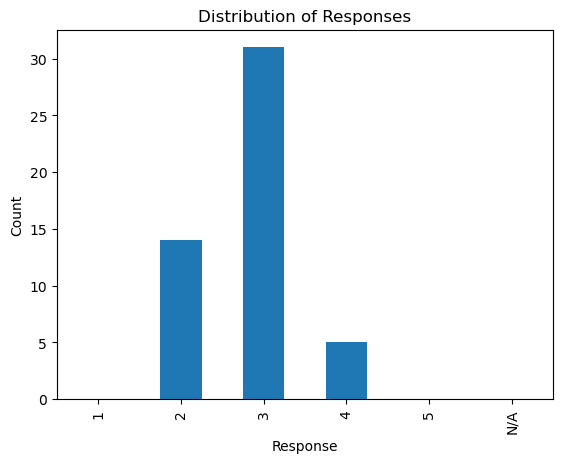

In [23]:

df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar')
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Distribution of Responses')

In [24]:
# compute the average and std scores
average_score = df["response"].replace("N/A", pd.NA).astype(float).mean()
std_score = df["response"].replace("N/A", pd.NA).astype(float).std()
print(f"Average score: {average_score:.2f}")
print(f"Standard deviation of scores: {std_score:.2f}")

Average score: 2.82
Standard deviation of scores: 0.60


In [25]:
is_there_a_good_market(df)

Percentage of positive responses (4-5): 10.00%
Percentage of neutral responses (3): 62.00%
Percentage of negative responses (1-2): 28.00%
Percentage of 'N/A' responses: 0.00%
Mean response: 2.82
Standard deviation of responses: 0.60
VERDICT: There is not a good market for bottled gazpacho.


False

We can also chat with the agents in an ad-hoc way, to get a more detailed understanding if needed.

In [26]:
from tinytroupe.ui import AgentChatJupyterWidget

# Create and display the enhanced chat widget
chat_interface = AgentChatJupyterWidget(people)
chat_interface.display()

In [27]:
#control.end()

## Empirical Data Validation
Now let's see how the above matches the same research done with actual real people!

In [28]:
control_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_csv(
            file_path="../data/empirical/07.19.2025 - Market Research - Bottled Gazpacho - Raw Data.csv",
            experimental_data_type="single_value_per_agent",
            agent_id_column="Responder #",
            value_column="Vote",
            agent_comments_column="Explanation",
            agent_attributes_columns=["Age Range", "Gender Identity", "Political Affiliation", "Racial Or Ethnic Identity"],
            dataset_name="Test Gazpacho Survey"
        )

In [29]:
control_data

SimulationExperimentDataset(name='Test Gazpacho Survey', description='Empirical data loaded from 07.19.2025 - Market Research - Bottled Gazpacho - Raw Data.csv', key_results={'Vote': [4, 1, 1, 5, 3, 4, 2, 4, 1, 1, 3, 2, 2, 5, 4, 3, 3, 5, 4, 2, 3, 5, 3, 3, 5, 1, 3, 4, 3, 1, 1, 4, 3, 3, 2, 1, 4, 3, 4, 2, 1, 1, 2, 1, 2, 5, 2, 4, 3, 5]}, result_types={'Vote': 'per_agent'}, data_types={'Vote': 'ranking'}, categorical_mappings={}, ordinal_mappings={}, ranking_info={'Vote': {'min_rank': 1, 'max_rank': 5, 'num_ranks': 5, 'rank_values': [1, 2, 3, 4, 5], 'direction': 'ascending'}}, agent_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50'], agent_justifications=[{'agent_name': '1', 'agent_index': 0, 'justification': 'Yes because it is something i have nev

<Axes: xlabel='0'>

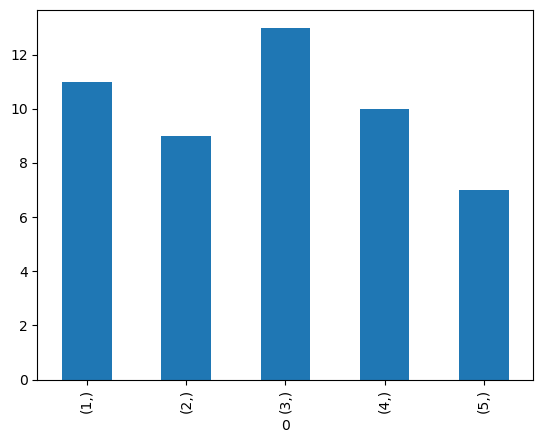

In [30]:
pd.DataFrame(control_data.key_results["Vote"]).value_counts().sort_index().plot(kind="bar")

In [31]:
# Convert string responses to numeric values and rename column to match control_data
df_for_validation = df.copy()
df_for_validation["Vote"] = pd.to_numeric(df_for_validation["response"], errors='coerce')

# Create treatment data with matching column name and data type
treatment_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_dataframe(
    df=df_for_validation,
    experimental_data_type="single_value_per_agent",
    agent_id_column="name",
    value_column="Vote",
    agent_comments_column="justification",
    dataset_name="Bottled Gazpacho Simulation Results"
)

In [32]:
treatment_data

SimulationExperimentDataset(name='Bottled Gazpacho Simulation Results', description='Empirical data loaded from pandas DataFrame', key_results={'Vote': [4, 2, 3, 3, 3, 3, 2, 2, 3, 4, 3, 3, 2, 3, 3, 3, 2, 3, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 4, 2, 3, 3, 3, 2, 3, 2, 3, 4, 3, 2, 3, 2, 2, 3]}, result_types={'Vote': 'per_agent'}, data_types={'Vote': 'count'}, categorical_mappings={}, ordinal_mappings={}, ranking_info={}, agent_names=['Catherine Elizabeth Montrose', 'Laura Bethany Palmer', 'Vivian Alexandra Blackwell', 'Daniel Marcus Everett', 'Susan Elaine Carter', 'Michelle Donovan', 'Colton James Mercer', 'Mason Eli Calloway', 'Naomi Elise Brooks', 'Ananya Reema Kapoor', 'Alexander Pierce', 'Noah Benjamin Harrington', 'Eleanor Beatrice Kensington', 'Lucas Minho Kim', 'Marisol Vega', 'Lena Harper', 'Mateo Cruz', 'Lucia Isabel Ramirez', 'Patricia Lorraine Keller', 'Taylor Montgomery Wells', 'Maisie Grace Holloway', 'Thomas Gregory Langford', "Eileen Margaret O'Connor", 'Priya 

In [33]:
result_ttest = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        output_format="values"
    )

In [34]:
result_ttest.overall_score

0.9981598386213923

In [35]:
result_ttest.statistical_results

{'common_metrics': ['Vote'],
 'test_results': {'treatment': {'Vote': {'test_type': 'Welch t-test (unequal variance)',
    'control_mean': 2.86,
    'treatment_mean': 2.82,
    'mean_difference': -0.040000000000000036,
    'percent_change': -1.3986013986014,
    't_statistic': 0.19104729493322747,
    'p_value': 0.8490642280846069,
    'confidence_interval': (-0.4578812358473646, 0.37788123584736455),
    'confidence_level': 0.95,
    'significant': False,
    'degrees_of_freedom': 67.2407541162003,
    'control_sample_size': 50,
    'treatment_sample_size': 50,
    'control_std': 1.3554124306434765,
    'treatment_std': 0.5955618167335951,
    'effect_size': -0.038209458986645496}}},
 'test_type': 'welch_t_test',
 'significance_level': 0.05}

In [36]:
result_ttest.semantic_results

In [37]:
result_ks = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        statistical_test_type="ks_test",
        output_format="values"
    )

In [38]:
result_ks.overall_score

0.8064516129032259

In [39]:
result_ks.statistical_results

{'common_metrics': ['Vote'],
 'test_results': {'treatment': {'Vote': {'test_type': 'Kolmogorov-Smirnov test',
    'control_mean': 2.86,
    'treatment_mean': 2.82,
    'control_median': 3.0,
    'treatment_median': 3.0,
    'control_std': 1.3554124306434765,
    'treatment_std': 0.5955618167335951,
    'ks_statistic': 0.24,
    'p_value': 0.11238524845512393,
    'significant': False,
    'control_sample_size': 50,
    'treatment_sample_size': 50,
    'effect_size': 0.24,
    'overlap_coefficient': 0.3698630136986302,
    'percentile_differences': {'p25_diff': 0.0,
     'p50_diff': 0.0,
     'p75_diff': -1.0,
     'p90_diff': -1.8999999999999986,
     'p95_diff': -1.0},
    'interpretation': 'No significant difference between distributions',
    'confidence_level': 0.95}}},
 'test_type': 'ks_test',
 'significance_level': 0.05}

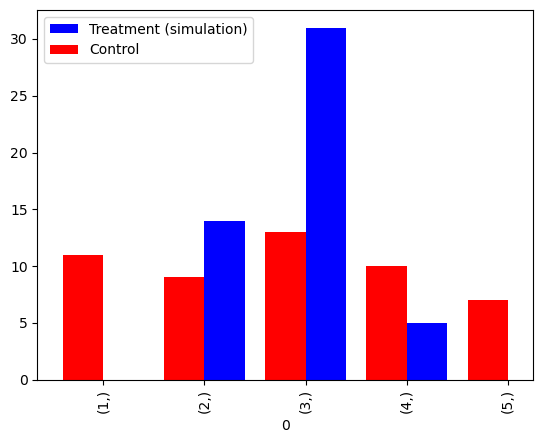

In [40]:
# compare charts. Put both bars in the same plot, for easier comparison
# Need to order the labels in the chart.
fig, ax = plt.subplots()
df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar', color='blue', position=0, width=0.4, label="Treatment (simulation)", ax=ax)
pd.DataFrame(control_data.key_results["Vote"]).value_counts().sort_index().plot(kind='bar', color='red', position=1, width=0.4, label="Control", ax=ax)
plt.legend()
plt.show()

In [41]:
df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"])

response
1       NaN
2      14.0
3      31.0
4       5.0
5       NaN
N/A     NaN
Name: count, dtype: float64